## Cell type annotation by scArches label transfer
Train scArches VAE model on Fly Cell Atlas head reference dataset and predict cell types labels for w1118_42d and drprnull_42d samples

In [1]:
!python --version

Python 3.12.2


## Load required packages

In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import torch
import scvi
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
from scipy.sparse import csr_matrix
from scipy.stats import median_abs_deviation
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import gdown
import copy as cp
import os
import plotnine as p
import pickle

sns.set_style('white')
sns.set(font_scale=1.5)
sc.settings.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()
sc.settings.verbosity = 3


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


scanpy==1.10.0 anndata==0.10.6 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


## Check GPU availability and configuration

In [3]:
print(os.getenv("CUDA_VISIBLE_DEVICES"))
os.environ["CUDA_VISIBLE_DEVICES"]=os.getenv("CUDA_VISIBLE_DEVICES")

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

6
True
1
0
NVIDIA A40


## Set up I/O and read reference and query datasets
Fly cell atlas head and antenna datasets will be used as references, obtained from https://flycellatlas.org/
10x raw H5AD files were downloaded for both head and antenna

In [4]:
## Set up I/O directories
basepath = Path("/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/")
referencepath = basepath.joinpath('reference','FCA')
inputpath = basepath.joinpath('analysis','preprocess')
outputpath = basepath.joinpath('analysis','scarches')




In [5]:
## Read reference dataset
fca_reference_head = sc.read_h5ad(referencepath.joinpath("v2_fca_biohub_head_10x_raw.h5ad"))
fca_reference_head.raw = fca_reference_head

## combine tissue and batch info from each dataset to for unique categorical covariates 
fca_reference_head.obs['tissue'] = "fca_head"
fca_reference_head.obs['tissue_batch'] = fca_reference_head.obs['batch'].astype(str)+"_"+fca_reference_head.obs['tissue'].astype(str)

print(fca_reference_head.shape)

(100527, 13056)


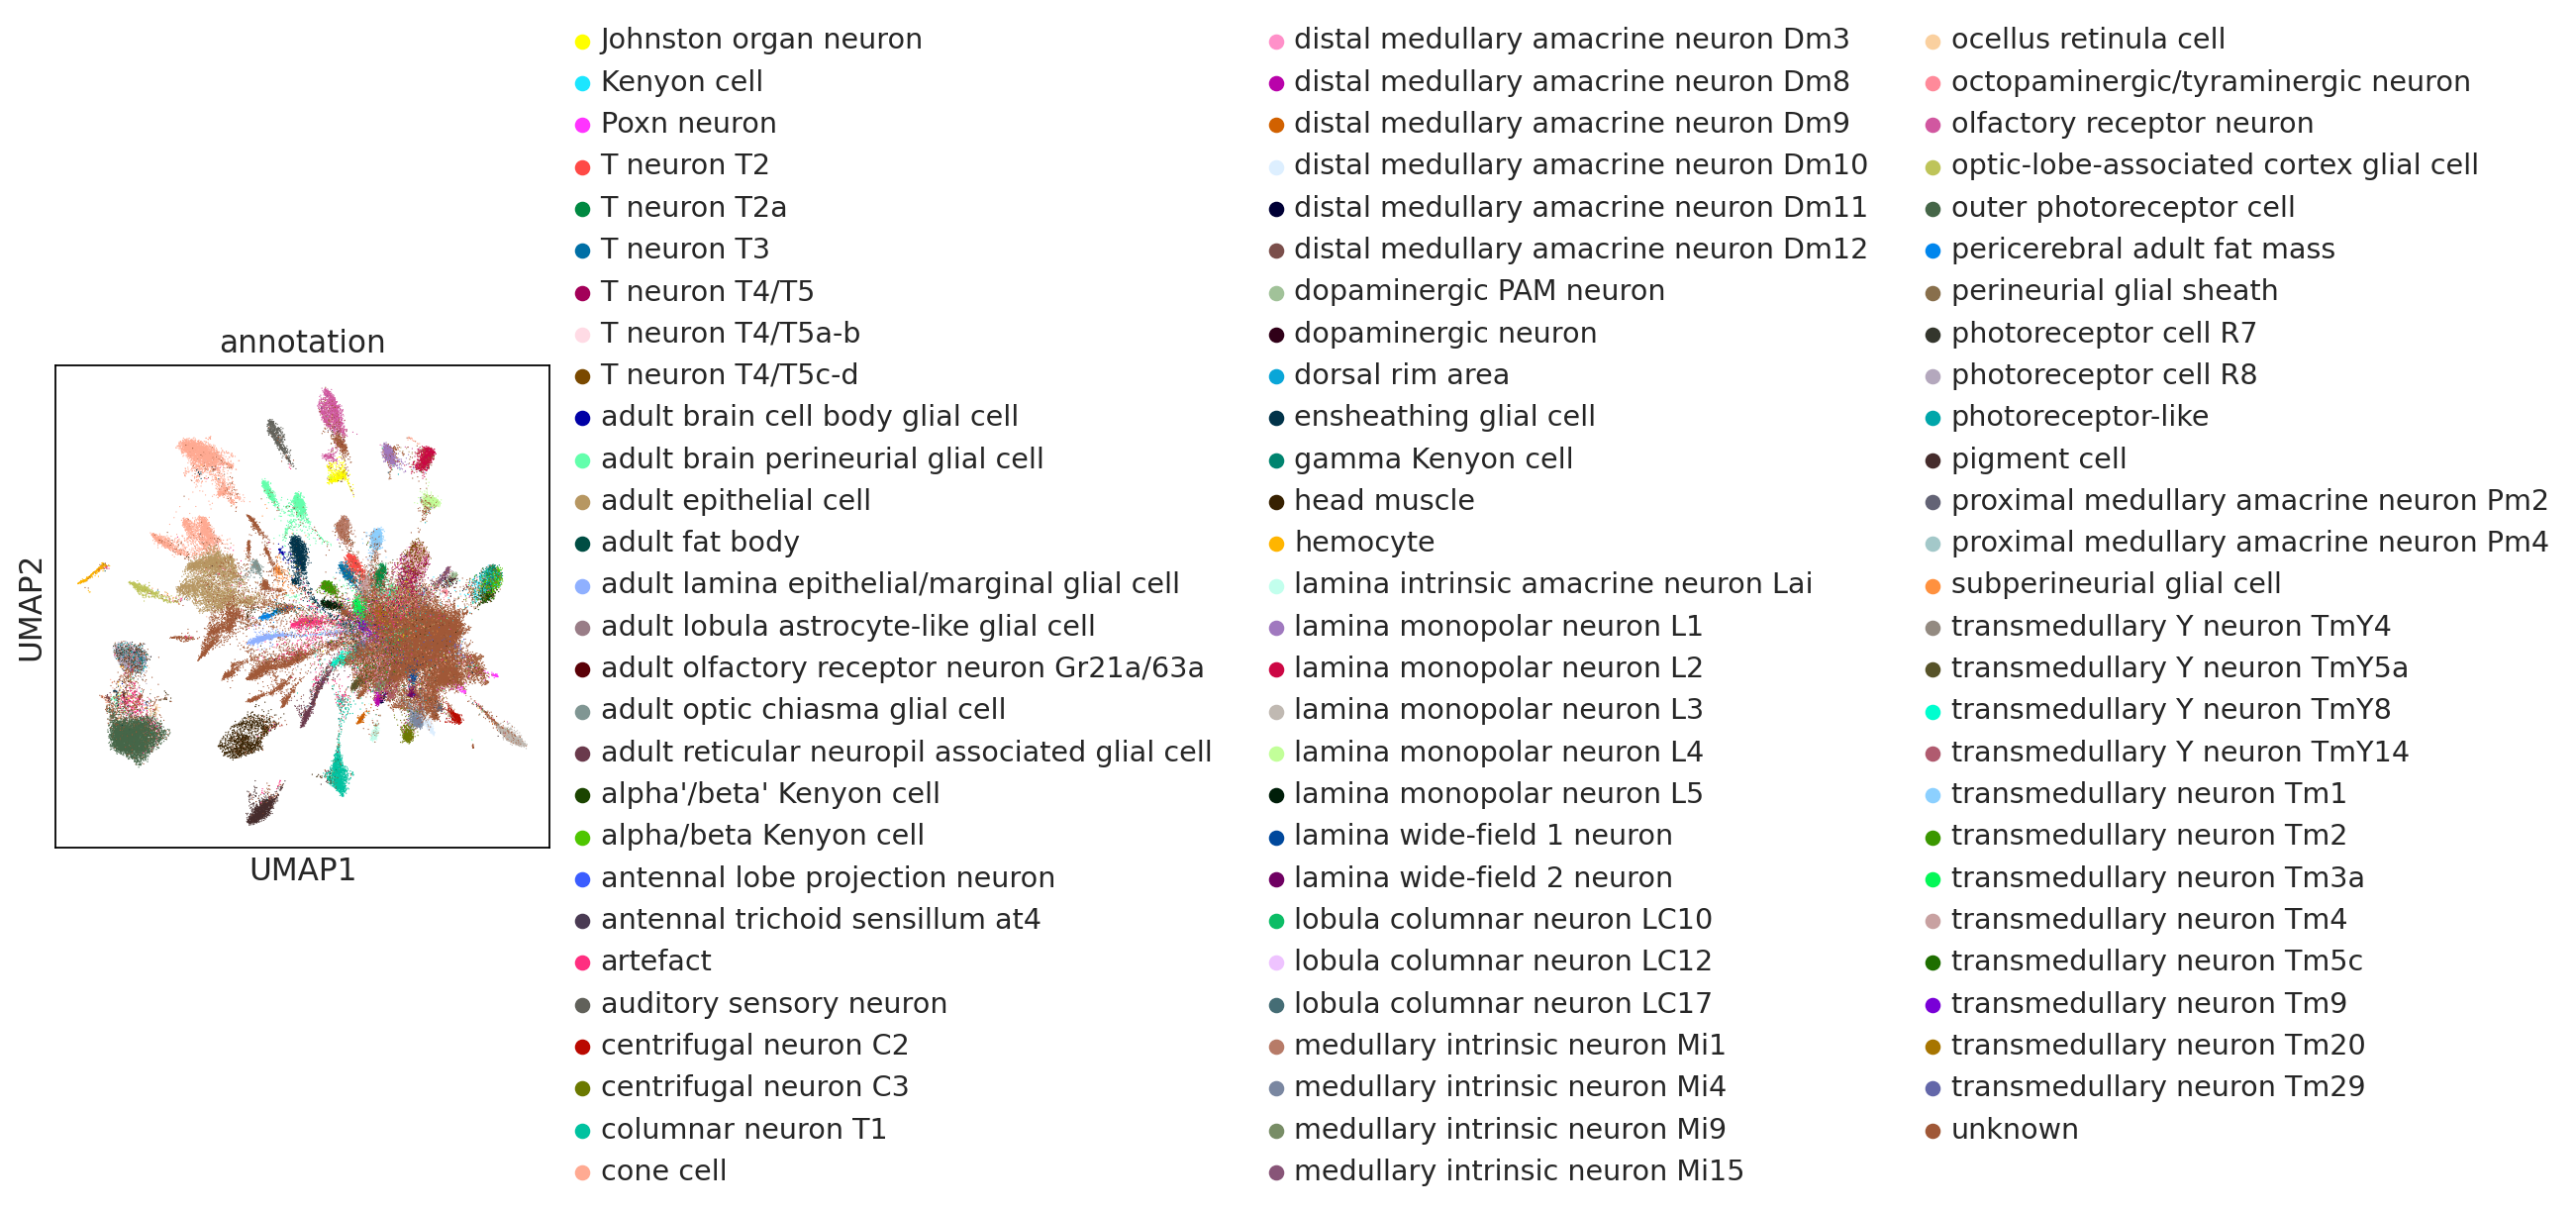

In [6]:
sc.pl.umap(fca_reference_head,color="annotation")

In [7]:
## read query datasets
w1118_42d = sc.read_h5ad(inputpath.joinpath('w1118_42d_sc.h5'))
w1118_42d.raw = w1118_42d

w1118_42d.obs['batch'] = "0"
w1118_42d.obs['age'] = "42"
w1118_42d.obs['sex'] = "mix"
w1118_42d.obs['fly_genetics'] = "W1118" #NOT lower case w1118 to match reference. 
w1118_42d.obs['dissection_lab'] = "mccall"
w1118_42d.obs['tissue'] = "w1118_head"
w1118_42d.obs['tissue_batch'] = w1118_42d.obs['batch'].astype(str)+"_"+w1118_42d.obs['tissue'].astype(str)

w1118_42d.obs['batch'] = w1118_42d.obs['batch'].astype('category')
w1118_42d.obs['age'] = w1118_42d.obs['age'].astype('category')
w1118_42d.obs['sex'] = w1118_42d.obs['sex'].astype('category')
w1118_42d.obs['fly_genetics'] = w1118_42d.obs['fly_genetics'].astype('category')
w1118_42d.obs['dissection_lab'] = w1118_42d.obs['dissection_lab'].astype('category')
w1118_42d.obs['tissue'] = w1118_42d.obs['tissue'].astype('category')
w1118_42d.obs['tissue_batch'] = w1118_42d.obs['tissue_batch'].astype('category')

print(w1118_42d.shape)


(8200, 11652)


In [8]:
drprnull_42d = sc.read_h5ad(inputpath.joinpath('drprnull_42d_sc.h5'))
drprnull_42d.raw = drprnull_42d

drprnull_42d.obs['batch'] = "0"
drprnull_42d.obs['age'] = "42"
drprnull_42d.obs['sex'] = "mix"
drprnull_42d.obs['fly_genetics'] = "drprnull"
drprnull_42d.obs['dissection_lab'] = "mccall"
drprnull_42d.obs['tissue'] = "drprnull_head"
drprnull_42d.obs['tissue_batch'] = drprnull_42d.obs['batch'].astype(str)+"_"+drprnull_42d.obs['tissue'].astype(str)

drprnull_42d.obs['batch'] = drprnull_42d.obs['batch'].astype('category')
drprnull_42d.obs['age'] = drprnull_42d.obs['age'].astype('category')
drprnull_42d.obs['sex'] = drprnull_42d.obs['sex'].astype('category')
drprnull_42d.obs['fly_genetics'] = drprnull_42d.obs['fly_genetics'].astype('category')
drprnull_42d.obs['dissection_lab'] = drprnull_42d.obs['dissection_lab'].astype('category')
drprnull_42d.obs['tissue'] = drprnull_42d.obs['tissue'].astype('category')
drprnull_42d.obs['tissue_batch'] = drprnull_42d.obs['tissue_batch'].astype('category')

print(drprnull_42d.shape)

(6121, 11903)


In [9]:
print(w1118_42d.X.min(),w1118_42d.X.max())
print(drprnull_42d.X.min(),drprnull_42d.X.max())
print(fca_reference_head.X.min(),fca_reference_head.X.max())

0.0 714.0
0.0 1089.0
0.0 1444.0


In [10]:
query = sc.concat([w1118_42d,drprnull_42d], join='outer')
query

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 14321 × 12349
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'log1p_total_counts_mt', 'outlier', 'mt_outlier', 'batch', 'age', 'sex', 'fly_genetics', 'dissection_lab', 'tissue', 'tissue_batch'

## Train model on head reference 

In [11]:
combined = sc.concat([query, fca_reference_head], join='outer')
combined

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 114848 × 13462
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'log1p_total_counts_mt', 'outlier', 'mt_outlier', 'batch', 'age', 'sex', 'fly_genetics', 'dissection_lab', 'tissue', 'tissue_batch', 'batch_id', 'celda_decontx__clusters', 'celda_decontx__contamination', 'celda_decontx__doublemad_predicted_outliers', 'fca_id', 'id', 'log_n_counts', 'log_n_genes', 'n_counts', 'note', 'percent_mito', 'sample_id', 'scrublet__doublet_scores', 'scrublet__predicted_doublets', 'scrublet__predicted_doublets_based_on_10x_chromium_spec', 'leiden_res0.4', 'leiden_res0.6', 'leiden_res0.8', 'leiden_res1.0', 'leiden_res1.2', 'leiden_res1.4', 'leiden_res1.6', 'leiden_res1.8', 'leiden_res10.0', 'leiden_res12.0', 'leiden_res14.0', 'leiden_res16.0', 'leiden_res18.0', 'leiden_res2.0', 'leiden_res20.0', 'leiden_res25.0', 'leiden_res4.0', 'leiden_res50.

In [12]:
combined.obs

n_genes_by_counts  \
AAACCCAAGAGAGCAA-1                                              444.0   
AAACCCAAGCCGGATA-1                                              686.0   
AAACCCACATAATGCC-1                                              809.0   
AAACCCATCAAGGCTT-1                                              427.0   
AAACGAAAGGATACGC-1                                              766.0   
...                                                               ...   
TTTGGTTGTACGAAAT-f7ed0992__FCA15_Female_head_adult                NaN   
TTTGTTGCAACGCATT-f7ed0992__FCA15_Female_head_adult                NaN   
TTTGTTGTCATCGCCT-f7ed0992__FCA15_Female_head_adult                NaN   
TTTGTTGTCCATTCGC-f7ed0992__FCA15_Female_head_adult                NaN   
TTTGTTGTCGCTTGCT-f7ed0992__FCA15_Female_head_adult                NaN   

                                                    total_counts  \
AAACCCAAGAGAGCAA-1                                         823.0   
AAACCCAAGCCGGATA-1                                        1138.0   
AAACCCACATAATGCC-1                                        1573.0   
AAACCCATCAAGGCTT-1                                         693.0   
AAACGAAAGGATACGC-1                                        1424.0   
...                                                          ...   
TTTGGTTGTACGAAAT-f7ed0992__FCA15_Female_head_adult           NaN   
TTTGTTGCAACGCATT-f7ed0992__FCA15_Female_head_adult           NaN   
TTTGTTGTCATCGCCT-f7ed0992__FCA15_Female_head_adult           NaN   
TTTGTTGTCCATTCGC-f7ed0992__FCA15_Female_head_adult           NaN   
TTTGTTGTCGCTTGCT-f7ed0992__FCA15_Female_head_adult           NaN   

                                                    total_counts_mt  \
AAACCCAAGAGAGCAA-1                                              1.0   
AAACCCAAGCCGGATA-1                                              3.0   
AAACCCACATAATGCC-1                                              1.0   
AAACCCATCAAGGCTT-1                                              2.0   
AAACGAAAGGATACGC-1                                              4.0   
...                                                             ...   
TTTGGTTGTACGAAAT-f7ed0992__FCA15_Female_head_adult              NaN   
TTTGTTGCAACGCATT-f7ed0992__FCA15_Female_head_adult              NaN   
TTTGTTGTCATCGCCT-f7ed0992__FCA15_Female_head_adult              NaN   
TTTGTTGTCCATTCGC-f7ed0992__FCA15_Female_head_adult              NaN   
TTTGTTGTCGCTTGCT-f7ed0992__FCA15_Female_head_adult              NaN   

                                                    pct_counts_mt  n_genes  \
AAACCCAAGAGAGCAA-1                                       0.121507      444   
AAACCCAAGCCGGATA-1                                       0.263620      686   
AAACCCACATAATGCC-1                                       0.063573      809   
AAACCCATCAAGGCTT-1                                       0.288600      427   
AAACGAAAGGATACGC-1                                       0.280899      768   
...                                                           ...      ...   
TTTGGTTGTACGAAAT-f7ed0992__FCA15_Female_head_adult            NaN      335   
TTTGTTGCAACGCATT-f7ed0992__FCA15_Female_head_adult            NaN      444   
TTTGTTGTCATCGCCT-f7ed0992__FCA15_Female_head_adult            NaN      389   
TTTGTTGTCCATTCGC-f7ed0992__FCA15_Female_head_adult            NaN     1093   
TTTGTTGTCGCTTGCT-f7ed0992__FCA15_Female_head_adult            NaN      468   

                                                    log1p_n_genes_by_counts  \
AAACCCAAGAGAGCAA-1                                                 6.098074   
AAACCCAAGCCGGATA-1                                                 6.532334   
AAACCCACATAATGCC-1                                                 6.697034   
AAACCCATCAAGGCTT-1                                                 6.059123   
AAACGAAAGGATACGC-1                                                 6.642487   
...                                                                     ...   
TTTGGTTGTACGAAA

In [13]:
print(combined.X.max(),combined.X.min())

1444.0 0.0


In [14]:
combined.layers['counts'] = combined.X.copy()
sc.pp.normalize_total(combined, target_sum=1e4)
sc.pp.log1p(combined)
combined.raw = combined


normalizing counts per cell
    finished (0:00:00)


In [15]:
print(combined.layers['counts'].max(),combined.layers['counts'].min())
print(combined.X.max(),combined.X.min())

1444.0 0.0
8.615613 0.0


In [16]:
sc.pp.highly_variable_genes(
    combined,
    n_top_genes=2000,
    batch_key="tissue_batch",
    subset=True)
combined

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 114848 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'log1p_total_counts_mt', 'outlier', 'mt_outlier', 'batch', 'age', 'sex', 'fly_genetics', 'dissection_lab', 'tissue', 'tissue_batch', 'batch_id', 'celda_decontx__clusters', 'celda_decontx__contamination', 'celda_decontx__doublemad_predicted_outliers', 'fca_id', 'id', 'log_n_counts', 'log_n_genes', 'n_counts', 'note', 'percent_mito', 'sample_id', 'scrublet__doublet_scores', 'scrublet__predicted_doublets', 'scrublet__predicted_doublets_based_on_10x_chromium_spec', 'leiden_res0.4', 'leiden_res0.6', 'leiden_res0.8', 'leiden_res1.0', 'leiden_res1.2', 'leiden_res1.4', 'leiden_res1.6', 'leiden_res1.8', 'leiden_res10.0', 'leiden_res12.0', 'leiden_res14.0', 'leiden_res16.0', 'leiden_res18.0', 'leiden_res2.0', 'leiden_res20.0', 'leiden_res25.0', 'leiden_res4.0', 'leiden_res50.0

In [17]:
sca.models.SCVI.setup_anndata(combined, 
                              batch_key="tissue_batch",
                              categorical_covariate_keys=["age","fly_genetics","tissue","dissection_lab","sex"])

vae = sca.models.SCVI(
    combined,
    n_layers=2,
    n_latent=30,
    encode_covariates=True,
    deeply_inject_covariates=True,
    use_layer_norm="both",
    use_batch_norm="none"
)
vae.train(max_epochs=200, check_val_every_n_epoch = 1)
print(vae)

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6]


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 2/200:   0%|          | 1/200 [00:06<22:22,  6.75s/it, v_num=1, train_loss_step=309, train_loss_epoch=329]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 3/200:   1%|          | 2/200 [00:13<21:50,  6.62s/it, v_num=1, train_loss_step=286, train_loss_epoch=305]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 4/200:   2%|▏         | 3/200 [00:19<21:35,  6.58s/it, v_num=1, train_loss_step=306, train_loss_epoch=297]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 5/200:   2%|▏         | 4/200 [00:26<21:26,  6.56s/it, v_num=1, train_loss_step=290, train_loss_epoch=292]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 6/200:   2%|▎         | 5/200 [00:32<21:18,  6.56s/it, v_num=1, train_loss_step=294, train_loss_epoch=289]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 7/200:   3%|▎         | 6/200 [00:39<21:09,  6.54s/it, v_num=1, train_loss_step=276, train_loss_epoch=286]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 8/200:   4%|▎         | 7/200 [00:45<21:02,  6.54s/it, v_num=1, train_loss_step=269, train_loss_epoch=284]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 9/200:   4%|▍         | 8/200 [00:52<20:57,  6.55s/it, v_num=1, train_loss_step=278, train_loss_epoch=282]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 10/200:   4%|▍         | 9/200 [00:59<20:50,  6.55s/it, v_num=1, train_loss_step=307, train_loss_epoch=281]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 11/200:   5%|▌         | 10/200 [01:05<20:43,  6.54s/it, v_num=1, train_loss_step=275, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 12/200:   6%|▌         | 11/200 [01:12<20:35,  6.53s/it, v_num=1, train_loss_step=297, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 13/200:   6%|▌         | 12/200 [01:18<20:28,  6.53s/it, v_num=1, train_loss_step=294, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 14/200:   6%|▋         | 13/200 [01:25<20:23,  6.54s/it, v_num=1, train_loss_step=290, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 15/200:   7%|▋         | 14/200 [01:31<20:16,  6.54s/it, v_num=1, train_loss_step=261, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 16/200:   8%|▊         | 15/200 [01:38<20:06,  6.52s/it, v_num=1, train_loss_step=277, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 17/200:   8%|▊         | 16/200 [01:44<19:57,  6.51s/it, v_num=1, train_loss_step=264, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 18/200:   8%|▊         | 17/200 [01:51<19:48,  6.50s/it, v_num=1, train_loss_step=274, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 19/200:   9%|▉         | 18/200 [01:57<19:43,  6.50s/it, v_num=1, train_loss_step=282, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 20/200:  10%|▉         | 19/200 [02:04<19:35,  6.50s/it, v_num=1, train_loss_step=262, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 21/200:  10%|█         | 20/200 [02:10<19:28,  6.49s/it, v_num=1, train_loss_step=268, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 22/200:  10%|█         | 21/200 [02:17<19:20,  6.48s/it, v_num=1, train_loss_step=273, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 23/200:  11%|█         | 22/200 [02:23<19:15,  6.49s/it, v_num=1, train_loss_step=273, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 24/200:  12%|█▏        | 23/200 [02:30<19:08,  6.49s/it, v_num=1, train_loss_step=280, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 25/200:  12%|█▏        | 24/200 [02:36<19:01,  6.49s/it, v_num=1, train_loss_step=286, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 26/200:  12%|█▎        | 25/200 [02:43<18:54,  6.48s/it, v_num=1, train_loss_step=273, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 27/200:  13%|█▎        | 26/200 [02:49<18:47,  6.48s/it, v_num=1, train_loss_step=288, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 28/200:  14%|█▎        | 27/200 [02:56<18:42,  6.49s/it, v_num=1, train_loss_step=271, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 29/200:  14%|█▍        | 28/200 [03:02<18:37,  6.50s/it, v_num=1, train_loss_step=260, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 30/200:  14%|█▍        | 29/200 [03:09<18:30,  6.50s/it, v_num=1, train_loss_step=277, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 31/200:  15%|█▌        | 30/200 [03:15<18:25,  6.51s/it, v_num=1, train_loss_step=259, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 32/200:  16%|█▌        | 31/200 [03:22<18:20,  6.51s/it, v_num=1, train_loss_step=285, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 33/200:  16%|█▌        | 32/200 [03:28<18:14,  6.52s/it, v_num=1, train_loss_step=253, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 34/200:  16%|█▋        | 33/200 [03:35<18:08,  6.52s/it, v_num=1, train_loss_step=287, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 35/200:  17%|█▋        | 34/200 [03:41<18:02,  6.52s/it, v_num=1, train_loss_step=257, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 36/200:  18%|█▊        | 35/200 [03:48<17:56,  6.53s/it, v_num=1, train_loss_step=261, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 37/200:  18%|█▊        | 36/200 [03:54<17:50,  6.53s/it, v_num=1, train_loss_step=272, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 38/200:  18%|█▊        | 37/200 [04:01<17:44,  6.53s/it, v_num=1, train_loss_step=295, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 39/200:  19%|█▉        | 38/200 [04:07<17:37,  6.53s/it, v_num=1, train_loss_step=271, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 40/200:  20%|█▉        | 39/200 [04:14<17:30,  6.52s/it, v_num=1, train_loss_step=254, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 41/200:  20%|██        | 40/200 [04:20<17:23,  6.52s/it, v_num=1, train_loss_step=275, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 42/200:  20%|██        | 41/200 [04:27<17:17,  6.52s/it, v_num=1, train_loss_step=260, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 43/200:  21%|██        | 42/200 [04:33<17:10,  6.52s/it, v_num=1, train_loss_step=277, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 44/200:  22%|██▏       | 43/200 [04:40<17:03,  6.52s/it, v_num=1, train_loss_step=288, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 45/200:  22%|██▏       | 44/200 [04:46<16:56,  6.52s/it, v_num=1, train_loss_step=272, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 46/200:  22%|██▎       | 45/200 [04:53<16:50,  6.52s/it, v_num=1, train_loss_step=281, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 47/200:  23%|██▎       | 46/200 [04:59<16:44,  6.52s/it, v_num=1, train_loss_step=252, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 48/200:  24%|██▎       | 47/200 [05:06<16:38,  6.52s/it, v_num=1, train_loss_step=288, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 49/200:  24%|██▍       | 48/200 [05:13<16:32,  6.53s/it, v_num=1, train_loss_step=269, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 50/200:  24%|██▍       | 49/200 [05:19<16:25,  6.53s/it, v_num=1, train_loss_step=284, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 51/200:  25%|██▌       | 50/200 [05:26<16:19,  6.53s/it, v_num=1, train_loss_step=283, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 52/200:  26%|██▌       | 51/200 [05:32<16:12,  6.53s/it, v_num=1, train_loss_step=272, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 53/200:  26%|██▌       | 52/200 [05:39<16:05,  6.52s/it, v_num=1, train_loss_step=268, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 54/200:  26%|██▋       | 53/200 [05:45<15:59,  6.53s/it, v_num=1, train_loss_step=258, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 55/200:  27%|██▋       | 54/200 [05:52<15:52,  6.53s/it, v_num=1, train_loss_step=263, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 56/200:  28%|██▊       | 55/200 [05:58<15:46,  6.53s/it, v_num=1, train_loss_step=280, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 57/200:  28%|██▊       | 56/200 [06:05<15:39,  6.53s/it, v_num=1, train_loss_step=282, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 58/200:  28%|██▊       | 57/200 [06:11<15:33,  6.53s/it, v_num=1, train_loss_step=288, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 59/200:  29%|██▉       | 58/200 [06:18<15:28,  6.54s/it, v_num=1, train_loss_step=288, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 60/200:  30%|██▉       | 59/200 [06:25<15:41,  6.68s/it, v_num=1, train_loss_step=287, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 61/200:  30%|███       | 60/200 [06:32<15:46,  6.76s/it, v_num=1, train_loss_step=269, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 62/200:  30%|███       | 61/200 [06:38<15:36,  6.74s/it, v_num=1, train_loss_step=267, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 63/200:  31%|███       | 62/200 [06:45<15:23,  6.69s/it, v_num=1, train_loss_step=269, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 64/200:  32%|███▏      | 63/200 [06:52<15:11,  6.65s/it, v_num=1, train_loss_step=273, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 65/200:  32%|███▏      | 64/200 [06:58<15:05,  6.66s/it, v_num=1, train_loss_step=300, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 66/200:  32%|███▎      | 65/200 [07:05<15:02,  6.69s/it, v_num=1, train_loss_step=266, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 67/200:  33%|███▎      | 66/200 [07:12<14:54,  6.68s/it, v_num=1, train_loss_step=278, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 68/200:  34%|███▎      | 67/200 [07:18<14:42,  6.64s/it, v_num=1, train_loss_step=267, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 69/200:  34%|███▍      | 68/200 [07:25<14:31,  6.60s/it, v_num=1, train_loss_step=273, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 70/200:  34%|███▍      | 69/200 [07:31<14:21,  6.58s/it, v_num=1, train_loss_step=280, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 71/200:  35%|███▌      | 70/200 [07:38<14:12,  6.56s/it, v_num=1, train_loss_step=247, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 72/200:  36%|███▌      | 71/200 [07:44<14:04,  6.54s/it, v_num=1, train_loss_step=278, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 73/200:  36%|███▌      | 72/200 [07:51<13:55,  6.53s/it, v_num=1, train_loss_step=290, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 74/200:  36%|███▋      | 73/200 [07:57<13:48,  6.52s/it, v_num=1, train_loss_step=288, train_loss_epoch=273]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 75/200:  37%|███▋      | 74/200 [08:04<13:41,  6.52s/it, v_num=1, train_loss_step=281, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 76/200:  38%|███▊      | 75/200 [08:10<13:34,  6.51s/it, v_num=1, train_loss_step=279, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 77/200:  38%|███▊      | 76/200 [08:17<13:27,  6.52s/it, v_num=1, train_loss_step=260, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 78/200:  38%|███▊      | 77/200 [08:23<13:22,  6.52s/it, v_num=1, train_loss_step=285, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 79/200:  39%|███▉      | 78/200 [08:30<13:18,  6.54s/it, v_num=1, train_loss_step=271, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 80/200:  40%|███▉      | 79/200 [08:37<13:11,  6.54s/it, v_num=1, train_loss_step=277, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 81/200:  40%|████      | 80/200 [08:43<13:05,  6.54s/it, v_num=1, train_loss_step=272, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 82/200:  40%|████      | 81/200 [08:50<13:01,  6.56s/it, v_num=1, train_loss_step=289, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 83/200:  41%|████      | 82/200 [08:56<12:55,  6.57s/it, v_num=1, train_loss_step=259, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 84/200:  42%|████▏     | 83/200 [09:03<12:58,  6.65s/it, v_num=1, train_loss_step=260, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 85/200:  42%|████▏     | 84/200 [09:10<12:57,  6.71s/it, v_num=1, train_loss_step=258, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 86/200:  42%|████▎     | 85/200 [09:17<12:49,  6.69s/it, v_num=1, train_loss_step=276, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 87/200:  43%|████▎     | 86/200 [09:23<12:40,  6.67s/it, v_num=1, train_loss_step=267, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 88/200:  44%|████▎     | 87/200 [09:30<12:27,  6.62s/it, v_num=1, train_loss_step=279, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 89/200:  44%|████▍     | 88/200 [09:36<12:17,  6.59s/it, v_num=1, train_loss_step=256, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 90/200:  44%|████▍     | 89/200 [09:43<12:10,  6.58s/it, v_num=1, train_loss_step=274, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 91/200:  45%|████▌     | 90/200 [09:49<12:03,  6.58s/it, v_num=1, train_loss_step=284, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 92/200:  46%|████▌     | 91/200 [09:56<11:56,  6.58s/it, v_num=1, train_loss_step=275, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 93/200:  46%|████▌     | 92/200 [10:02<11:47,  6.56s/it, v_num=1, train_loss_step=267, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 94/200:  46%|████▋     | 93/200 [10:09<11:39,  6.54s/it, v_num=1, train_loss_step=262, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 95/200:  47%|████▋     | 94/200 [10:15<11:32,  6.54s/it, v_num=1, train_loss_step=281, train_loss_epoch=274]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 96/200:  48%|████▊     | 95/200 [10:22<11:25,  6.53s/it, v_num=1, train_loss_step=274, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 97/200:  48%|████▊     | 96/200 [10:29<11:19,  6.54s/it, v_num=1, train_loss_step=287, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 98/200:  48%|████▊     | 97/200 [10:35<11:12,  6.53s/it, v_num=1, train_loss_step=268, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 99/200:  49%|████▉     | 98/200 [10:42<11:05,  6.52s/it, v_num=1, train_loss_step=265, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 100/200:  50%|████▉     | 99/200 [10:48<10:58,  6.52s/it, v_num=1, train_loss_step=276, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 101/200:  50%|█████     | 100/200 [10:55<10:52,  6.52s/it, v_num=1, train_loss_step=265, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 102/200:  50%|█████     | 101/200 [11:01<10:45,  6.52s/it, v_num=1, train_loss_step=262, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 103/200:  51%|█████     | 102/200 [11:08<10:38,  6.51s/it, v_num=1, train_loss_step=262, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 104/200:  52%|█████▏    | 103/200 [11:14<10:31,  6.51s/it, v_num=1, train_loss_step=271, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 105/200:  52%|█████▏    | 104/200 [11:21<10:27,  6.53s/it, v_num=1, train_loss_step=285, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 106/200:  52%|█████▎    | 105/200 [11:27<10:22,  6.55s/it, v_num=1, train_loss_step=282, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 107/200:  53%|█████▎    | 106/200 [11:34<10:15,  6.54s/it, v_num=1, train_loss_step=276, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 108/200:  54%|█████▎    | 107/200 [11:40<10:09,  6.55s/it, v_num=1, train_loss_step=277, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 109/200:  54%|█████▍    | 108/200 [11:47<10:02,  6.55s/it, v_num=1, train_loss_step=282, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 110/200:  55%|█████▍    | 109/200 [11:53<09:53,  6.52s/it, v_num=1, train_loss_step=281, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 111/200:  55%|█████▌    | 110/200 [12:00<09:45,  6.51s/it, v_num=1, train_loss_step=270, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 112/200:  56%|█████▌    | 111/200 [12:06<09:41,  6.53s/it, v_num=1, train_loss_step=304, train_loss_epoch=275]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 113/200:  56%|█████▌    | 112/200 [12:13<09:33,  6.51s/it, v_num=1, train_loss_step=293, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 114/200:  56%|█████▋    | 113/200 [12:19<09:26,  6.52s/it, v_num=1, train_loss_step=293, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 115/200:  57%|█████▋    | 114/200 [12:26<09:18,  6.50s/it, v_num=1, train_loss_step=278, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 116/200:  57%|█████▊    | 115/200 [12:32<09:14,  6.52s/it, v_num=1, train_loss_step=261, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 117/200:  58%|█████▊    | 116/200 [12:39<09:10,  6.55s/it, v_num=1, train_loss_step=266, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 118/200:  58%|█████▊    | 117/200 [12:46<09:05,  6.58s/it, v_num=1, train_loss_step=258, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 119/200:  59%|█████▉    | 118/200 [12:52<08:59,  6.58s/it, v_num=1, train_loss_step=281, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 120/200:  60%|█████▉    | 119/200 [12:59<08:50,  6.55s/it, v_num=1, train_loss_step=284, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 121/200:  60%|██████    | 120/200 [13:05<08:43,  6.54s/it, v_num=1, train_loss_step=286, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 122/200:  60%|██████    | 121/200 [13:12<08:38,  6.56s/it, v_num=1, train_loss_step=276, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 123/200:  61%|██████    | 122/200 [13:19<08:32,  6.57s/it, v_num=1, train_loss_step=278, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 124/200:  62%|██████▏   | 123/200 [13:25<08:26,  6.58s/it, v_num=1, train_loss_step=282, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 125/200:  62%|██████▏   | 124/200 [13:32<08:18,  6.56s/it, v_num=1, train_loss_step=290, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 126/200:  62%|██████▎   | 125/200 [13:38<08:09,  6.53s/it, v_num=1, train_loss_step=279, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 127/200:  63%|██████▎   | 126/200 [13:45<08:02,  6.51s/it, v_num=1, train_loss_step=268, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 128/200:  64%|██████▎   | 127/200 [13:51<07:56,  6.52s/it, v_num=1, train_loss_step=260, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 129/200:  64%|██████▍   | 128/200 [13:58<07:51,  6.54s/it, v_num=1, train_loss_step=287, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 130/200:  64%|██████▍   | 129/200 [14:04<07:43,  6.52s/it, v_num=1, train_loss_step=260, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 131/200:  65%|██████▌   | 130/200 [14:11<07:35,  6.51s/it, v_num=1, train_loss_step=298, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 132/200:  66%|██████▌   | 131/200 [14:17<07:28,  6.49s/it, v_num=1, train_loss_step=253, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 133/200:  66%|██████▌   | 132/200 [14:24<07:23,  6.52s/it, v_num=1, train_loss_step=295, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 134/200:  66%|██████▋   | 133/200 [14:30<07:16,  6.51s/it, v_num=1, train_loss_step=284, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 135/200:  67%|██████▋   | 134/200 [14:37<07:09,  6.50s/it, v_num=1, train_loss_step=278, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 136/200:  68%|██████▊   | 135/200 [14:43<07:02,  6.51s/it, v_num=1, train_loss_step=295, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 137/200:  68%|██████▊   | 136/200 [14:50<06:57,  6.52s/it, v_num=1, train_loss_step=248, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 138/200:  68%|██████▊   | 137/200 [14:56<06:49,  6.50s/it, v_num=1, train_loss_step=275, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 139/200:  69%|██████▉   | 138/200 [15:03<06:44,  6.52s/it, v_num=1, train_loss_step=283, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 140/200:  70%|██████▉   | 139/200 [15:09<06:38,  6.54s/it, v_num=1, train_loss_step=300, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 141/200:  70%|███████   | 140/200 [15:16<06:33,  6.55s/it, v_num=1, train_loss_step=294, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 142/200:  70%|███████   | 141/200 [15:23<06:27,  6.57s/it, v_num=1, train_loss_step=270, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 143/200:  71%|███████   | 142/200 [15:29<06:20,  6.56s/it, v_num=1, train_loss_step=291, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 144/200:  72%|███████▏  | 143/200 [15:36<06:12,  6.53s/it, v_num=1, train_loss_step=272, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 145/200:  72%|███████▏  | 144/200 [15:42<06:04,  6.51s/it, v_num=1, train_loss_step=287, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 146/200:  72%|███████▎  | 145/200 [15:48<05:57,  6.50s/it, v_num=1, train_loss_step=268, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 147/200:  73%|███████▎  | 146/200 [15:55<05:50,  6.50s/it, v_num=1, train_loss_step=279, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 148/200:  74%|███████▎  | 147/200 [16:02<05:45,  6.52s/it, v_num=1, train_loss_step=285, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 149/200:  74%|███████▍  | 148/200 [16:08<05:38,  6.50s/it, v_num=1, train_loss_step=276, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 150/200:  74%|███████▍  | 149/200 [16:14<05:31,  6.50s/it, v_num=1, train_loss_step=276, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 151/200:  75%|███████▌  | 150/200 [16:21<05:25,  6.51s/it, v_num=1, train_loss_step=281, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 152/200:  76%|███████▌  | 151/200 [16:28<05:20,  6.54s/it, v_num=1, train_loss_step=280, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 153/200:  76%|███████▌  | 152/200 [16:34<05:13,  6.52s/it, v_num=1, train_loss_step=281, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 154/200:  76%|███████▋  | 153/200 [16:41<05:05,  6.50s/it, v_num=1, train_loss_step=298, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 155/200:  77%|███████▋  | 154/200 [16:47<04:58,  6.49s/it, v_num=1, train_loss_step=289, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 156/200:  78%|███████▊  | 155/200 [16:54<04:51,  6.48s/it, v_num=1, train_loss_step=255, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 157/200:  78%|███████▊  | 156/200 [17:00<04:44,  6.47s/it, v_num=1, train_loss_step=275, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 158/200:  78%|███████▊  | 157/200 [17:06<04:38,  6.47s/it, v_num=1, train_loss_step=283, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 159/200:  79%|███████▉  | 158/200 [17:13<04:32,  6.50s/it, v_num=1, train_loss_step=273, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 160/200:  80%|███████▉  | 159/200 [17:20<04:27,  6.53s/it, v_num=1, train_loss_step=275, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 161/200:  80%|████████  | 160/200 [17:26<04:21,  6.54s/it, v_num=1, train_loss_step=257, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 162/200:  80%|████████  | 161/200 [17:33<04:15,  6.56s/it, v_num=1, train_loss_step=288, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 163/200:  81%|████████  | 162/200 [17:39<04:09,  6.57s/it, v_num=1, train_loss_step=290, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 164/200:  82%|████████▏ | 163/200 [17:46<04:03,  6.57s/it, v_num=1, train_loss_step=281, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 165/200:  82%|████████▏ | 164/200 [17:53<03:56,  6.57s/it, v_num=1, train_loss_step=271, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 166/200:  82%|████████▎ | 165/200 [17:59<03:50,  6.58s/it, v_num=1, train_loss_step=278, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 167/200:  83%|████████▎ | 166/200 [18:06<03:43,  6.58s/it, v_num=1, train_loss_step=279, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 168/200:  84%|████████▎ | 167/200 [18:12<03:37,  6.59s/it, v_num=1, train_loss_step=286, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 169/200:  84%|████████▍ | 168/200 [18:19<03:30,  6.59s/it, v_num=1, train_loss_step=273, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 170/200:  84%|████████▍ | 169/200 [18:25<03:24,  6.59s/it, v_num=1, train_loss_step=275, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 171/200:  85%|████████▌ | 170/200 [18:32<03:16,  6.56s/it, v_num=1, train_loss_step=275, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 172/200:  86%|████████▌ | 171/200 [18:39<03:10,  6.56s/it, v_num=1, train_loss_step=283, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 173/200:  86%|████████▌ | 172/200 [18:45<03:04,  6.57s/it, v_num=1, train_loss_step=258, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 174/200:  86%|████████▋ | 173/200 [18:52<02:56,  6.54s/it, v_num=1, train_loss_step=301, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 175/200:  87%|████████▋ | 174/200 [18:58<02:49,  6.52s/it, v_num=1, train_loss_step=271, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 176/200:  88%|████████▊ | 175/200 [19:05<02:42,  6.50s/it, v_num=1, train_loss_step=295, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 177/200:  88%|████████▊ | 176/200 [19:11<02:35,  6.49s/it, v_num=1, train_loss_step=303, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 178/200:  88%|████████▊ | 177/200 [19:17<02:29,  6.49s/it, v_num=1, train_loss_step=280, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 179/200:  89%|████████▉ | 178/200 [19:24<02:22,  6.48s/it, v_num=1, train_loss_step=274, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 180/200:  90%|████████▉ | 179/200 [19:30<02:16,  6.48s/it, v_num=1, train_loss_step=285, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 181/200:  90%|█████████ | 180/200 [19:37<02:09,  6.48s/it, v_num=1, train_loss_step=282, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 182/200:  90%|█████████ | 181/200 [19:43<02:03,  6.47s/it, v_num=1, train_loss_step=276, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 183/200:  91%|█████████ | 182/200 [19:50<01:56,  6.47s/it, v_num=1, train_loss_step=268, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 184/200:  92%|█████████▏| 183/200 [19:56<01:50,  6.48s/it, v_num=1, train_loss_step=268, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 185/200:  92%|█████████▏| 184/200 [20:03<01:43,  6.49s/it, v_num=1, train_loss_step=276, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 186/200:  92%|█████████▎| 185/200 [20:09<01:37,  6.49s/it, v_num=1, train_loss_step=295, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 187/200:  93%|█████████▎| 186/200 [20:16<01:30,  6.48s/it, v_num=1, train_loss_step=293, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 188/200:  94%|█████████▎| 187/200 [20:22<01:24,  6.49s/it, v_num=1, train_loss_step=273, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 189/200:  94%|█████████▍| 188/200 [20:29<01:18,  6.50s/it, v_num=1, train_loss_step=280, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 190/200:  94%|█████████▍| 189/200 [20:35<01:11,  6.49s/it, v_num=1, train_loss_step=279, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 191/200:  95%|█████████▌| 190/200 [20:42<01:04,  6.48s/it, v_num=1, train_loss_step=278, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 192/200:  96%|█████████▌| 191/200 [20:48<00:58,  6.48s/it, v_num=1, train_loss_step=263, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 193/200:  96%|█████████▌| 192/200 [20:55<00:52,  6.50s/it, v_num=1, train_loss_step=263, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 194/200:  96%|█████████▋| 193/200 [21:01<00:45,  6.49s/it, v_num=1, train_loss_step=289, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 195/200:  97%|█████████▋| 194/200 [21:08<00:38,  6.48s/it, v_num=1, train_loss_step=287, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 196/200:  98%|█████████▊| 195/200 [21:14<00:32,  6.47s/it, v_num=1, train_loss_step=305, train_loss_epoch=281]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 197/200:  98%|█████████▊| 196/200 [21:21<00:25,  6.50s/it, v_num=1, train_loss_step=273, train_loss_epoch=281]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 198/200:  98%|█████████▊| 197/200 [21:27<00:19,  6.48s/it, v_num=1, train_loss_step=274, train_loss_epoch=281]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 199/200:  99%|█████████▉| 198/200 [21:34<00:12,  6.48s/it, v_num=1, train_loss_step=273, train_loss_epoch=281]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 200/200: 100%|█████████▉| 199/200 [21:40<00:06,  6.48s/it, v_num=1, train_loss_step=280, train_loss_epoch=281]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 200/200: 100%|██████████| 200/200 [21:47<00:00,  6.47s/it, v_num=1, train_loss_step=272, train_loss_epoch=281]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [21:47<00:00,  6.54s/it, v_num=1, train_loss_step=272, train_loss_epoch=281]


SCVI model with the following parameters: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

/scratch/6735487.1.iris-gpu-pub/ipykernel_95065/155314805.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


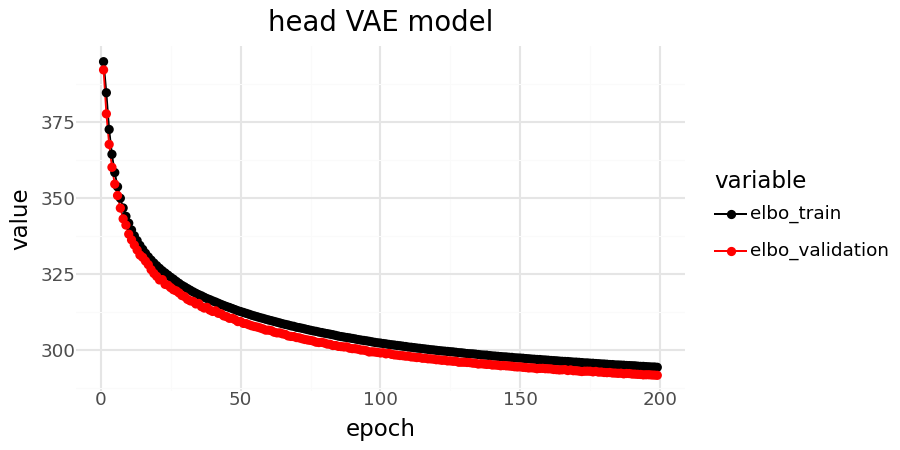

In [18]:
history_df = (
    vae.history['elbo_train'].astype(float)
    .join(vae.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 6, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.ggtitle("head VAE model")
    + p.theme_minimal()
)


print(p_)

In [19]:
head_model = "/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/analysis/scarches/head_model/"
vae.save(head_model, overwrite=True)

In [20]:
combined.obs['broad_annotation'] = combined.obs['broad_annotation'].cat.add_categories('Unlabeled')
combined.obs = combined.obs.fillna(value={'broad_annotation' : 'Unlabeled'})
combined.obs['annotation'] = combined.obs['annotation'].cat.add_categories('Unlabeled')
combined.obs = combined.obs.fillna(value={'annotation' : 'Unlabeled'})
combined.obs

n_genes_by_counts  \
AAACCCAAGAGAGCAA-1                                              444.0   
AAACCCAAGCCGGATA-1                                              686.0   
AAACCCACATAATGCC-1                                              809.0   
AAACCCATCAAGGCTT-1                                              427.0   
AAACGAAAGGATACGC-1                                              766.0   
...                                                               ...   
TTTGGTTGTACGAAAT-f7ed0992__FCA15_Female_head_adult                NaN   
TTTGTTGCAACGCATT-f7ed0992__FCA15_Female_head_adult                NaN   
TTTGTTGTCATCGCCT-f7ed0992__FCA15_Female_head_adult                NaN   
TTTGTTGTCCATTCGC-f7ed0992__FCA15_Female_head_adult                NaN   
TTTGTTGTCGCTTGCT-f7ed0992__FCA15_Female_head_adult                NaN   

                                                    total_counts  \
AAACCCAAGAGAGCAA-1                                         823.0   
AAACCCAAGCCGGATA-1                                        1138.0   
AAACCCACATAATGCC-1                                        1573.0   
AAACCCATCAAGGCTT-1                                         693.0   
AAACGAAAGGATACGC-1                                        1424.0   
...                                                          ...   
TTTGGTTGTACGAAAT-f7ed0992__FCA15_Female_head_adult           NaN   
TTTGTTGCAACGCATT-f7ed0992__FCA15_Female_head_adult           NaN   
TTTGTTGTCATCGCCT-f7ed0992__FCA15_Female_head_adult           NaN   
TTTGTTGTCCATTCGC-f7ed0992__FCA15_Female_head_adult           NaN   
TTTGTTGTCGCTTGCT-f7ed0992__FCA15_Female_head_adult           NaN   

                                                    total_counts_mt  \
AAACCCAAGAGAGCAA-1                                              1.0   
AAACCCAAGCCGGATA-1                                              3.0   
AAACCCACATAATGCC-1                                              1.0   
AAACCCATCAAGGCTT-1                                              2.0   
AAACGAAAGGATACGC-1                                              4.0   
...                                                             ...   
TTTGGTTGTACGAAAT-f7ed0992__FCA15_Female_head_adult              NaN   
TTTGTTGCAACGCATT-f7ed0992__FCA15_Female_head_adult              NaN   
TTTGTTGTCATCGCCT-f7ed0992__FCA15_Female_head_adult              NaN   
TTTGTTGTCCATTCGC-f7ed0992__FCA15_Female_head_adult              NaN   
TTTGTTGTCGCTTGCT-f7ed0992__FCA15_Female_head_adult              NaN   

                                                    pct_counts_mt  n_genes  \
AAACCCAAGAGAGCAA-1                                       0.121507      444   
AAACCCAAGCCGGATA-1                                       0.263620      686   
AAACCCACATAATGCC-1                                       0.063573      809   
AAACCCATCAAGGCTT-1                                       0.288600      427   
AAACGAAAGGATACGC-1                                       0.280899      768   
...                                                           ...      ...   
TTTGGTTGTACGAAAT-f7ed0992__FCA15_Female_head_adult            NaN      335   
TTTGTTGCAACGCATT-f7ed0992__FCA15_Female_head_adult            NaN      444   
TTTGTTGTCATCGCCT-f7ed0992__FCA15_Female_head_adult            NaN      389   
TTTGTTGTCCATTCGC-f7ed0992__FCA15_Female_head_adult            NaN     1093   
TTTGTTGTCGCTTGCT-f7ed0992__FCA15_Female_head_adult            NaN      468   

                                                    log1p_n_genes_by_counts  \
AAACCCAAGAGAGCAA-1                                                 6.098074   
AAACCCAAGCCGGATA-1                                                 6.532334   
AAACCCACATAATGCC-1                                                 6.697034   
AAACCCATCAAGGCTT-1                                                 6.059123   
AAACGAAAGGATACGC-1                                                 6.642487   
...                                                                     ...   
TTTGGTTGTACGAAA

In [21]:
broad_annotation_vae = sca.models.SCANVI.from_scvi_model(vae,adata=combined, unlabeled_category="Unlabeled",labels_key="broad_annotation")
broad_annotation_vae.train(max_epochs=50, check_val_every_n_epoch = 1)


INFO     Training for 50 epochs.                                                                                   


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6]


Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 2/50:   2%|▏         | 1/50 [00:14<11:30, 14.08s/it, v_num=1, train_loss_step=312, train_loss_epoch=320]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 3/50:   4%|▍         | 2/50 [00:27<11:10, 13.96s/it, v_num=1, train_loss_step=295, train_loss_epoch=305]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 4/50:   6%|▌         | 3/50 [00:41<10:51, 13.86s/it, v_num=1, train_loss_step=294, train_loss_epoch=301]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 5/50:   8%|▊         | 4/50 [00:55<10:41, 13.95s/it, v_num=1, train_loss_step=309, train_loss_epoch=299]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 6/50:  10%|█         | 5/50 [01:09<10:29, 14.00s/it, v_num=1, train_loss_step=279, train_loss_epoch=297]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 7/50:  12%|█▏        | 6/50 [01:23<10:16, 14.02s/it, v_num=1, train_loss_step=277, train_loss_epoch=295]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 8/50:  14%|█▍        | 7/50 [01:38<10:04, 14.05s/it, v_num=1, train_loss_step=288, train_loss_epoch=294]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 9/50:  16%|█▌        | 8/50 [01:52<09:49, 14.03s/it, v_num=1, train_loss_step=283, train_loss_epoch=293]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 10/50:  18%|█▊        | 9/50 [02:05<09:34, 14.01s/it, v_num=1, train_loss_step=303, train_loss_epoch=292]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 11/50:  20%|██        | 10/50 [02:19<09:19, 13.99s/it, v_num=1, train_loss_step=285, train_loss_epoch=291]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 12/50:  22%|██▏       | 11/50 [02:34<09:06, 14.01s/it, v_num=1, train_loss_step=287, train_loss_epoch=290]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 13/50:  24%|██▍       | 12/50 [02:47<08:52, 14.01s/it, v_num=1, train_loss_step=272, train_loss_epoch=289]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 14/50:  26%|██▌       | 13/50 [03:01<08:37, 13.99s/it, v_num=1, train_loss_step=287, train_loss_epoch=288]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 15/50:  28%|██▊       | 14/50 [03:16<08:25, 14.03s/it, v_num=1, train_loss_step=282, train_loss_epoch=287]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 16/50:  30%|███       | 15/50 [03:30<08:10, 14.02s/it, v_num=1, train_loss_step=299, train_loss_epoch=286]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 17/50:  32%|███▏      | 16/50 [03:44<07:57, 14.04s/it, v_num=1, train_loss_step=280, train_loss_epoch=285]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 18/50:  34%|███▍      | 17/50 [03:58<07:43, 14.05s/it, v_num=1, train_loss_step=263, train_loss_epoch=285]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 19/50:  36%|███▌      | 18/50 [04:12<07:29, 14.03s/it, v_num=1, train_loss_step=257, train_loss_epoch=284]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 20/50:  38%|███▊      | 19/50 [04:26<07:15, 14.06s/it, v_num=1, train_loss_step=290, train_loss_epoch=284]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 21/50:  40%|████      | 20/50 [04:40<07:00, 14.03s/it, v_num=1, train_loss_step=281, train_loss_epoch=283]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 22/50:  42%|████▏     | 21/50 [04:54<06:46, 14.03s/it, v_num=1, train_loss_step=262, train_loss_epoch=282]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 23/50:  44%|████▍     | 22/50 [05:08<06:32, 14.00s/it, v_num=1, train_loss_step=297, train_loss_epoch=282]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 24/50:  46%|████▌     | 23/50 [05:22<06:17, 13.97s/it, v_num=1, train_loss_step=288, train_loss_epoch=281]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 25/50:  48%|████▊     | 24/50 [05:36<06:03, 13.99s/it, v_num=1, train_loss_step=289, train_loss_epoch=281]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 26/50:  50%|█████     | 25/50 [05:50<05:49, 13.98s/it, v_num=1, train_loss_step=275, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 27/50:  52%|█████▏    | 26/50 [06:04<05:36, 14.01s/it, v_num=1, train_loss_step=280, train_loss_epoch=280]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 28/50:  54%|█████▍    | 27/50 [06:18<05:21, 13.97s/it, v_num=1, train_loss_step=298, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 29/50:  56%|█████▌    | 28/50 [06:32<05:07, 13.97s/it, v_num=1, train_loss_step=253, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 30/50:  58%|█████▊    | 29/50 [06:46<04:53, 13.97s/it, v_num=1, train_loss_step=267, train_loss_epoch=279]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 31/50:  60%|██████    | 30/50 [06:59<04:39, 13.96s/it, v_num=1, train_loss_step=267, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 32/50:  62%|██████▏   | 31/50 [07:14<04:25, 13.98s/it, v_num=1, train_loss_step=284, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 33/50:  64%|██████▍   | 32/50 [07:27<04:11, 13.97s/it, v_num=1, train_loss_step=251, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 34/50:  66%|██████▌   | 33/50 [07:41<03:57, 13.97s/it, v_num=1, train_loss_step=265, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 35/50:  68%|██████▊   | 34/50 [07:55<03:43, 13.98s/it, v_num=1, train_loss_step=301, train_loss_epoch=278]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 36/50:  70%|███████   | 35/50 [08:09<03:29, 13.99s/it, v_num=1, train_loss_step=312, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 37/50:  72%|███████▏  | 36/50 [08:24<03:17, 14.12s/it, v_num=1, train_loss_step=281, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 38/50:  74%|███████▍  | 37/50 [08:38<03:03, 14.10s/it, v_num=1, train_loss_step=299, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 39/50:  76%|███████▌  | 38/50 [08:52<02:49, 14.10s/it, v_num=1, train_loss_step=270, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 40/50:  78%|███████▊  | 39/50 [09:06<02:34, 14.08s/it, v_num=1, train_loss_step=279, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 41/50:  80%|████████  | 40/50 [09:20<02:20, 14.07s/it, v_num=1, train_loss_step=283, train_loss_epoch=277]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 42/50:  82%|████████▏ | 41/50 [09:34<02:06, 14.04s/it, v_num=1, train_loss_step=247, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 43/50:  84%|████████▍ | 42/50 [09:48<01:52, 14.07s/it, v_num=1, train_loss_step=281, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 44/50:  86%|████████▌ | 43/50 [10:02<01:38, 14.03s/it, v_num=1, train_loss_step=270, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 45/50:  88%|████████▊ | 44/50 [10:16<01:24, 14.03s/it, v_num=1, train_loss_step=287, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 46/50:  90%|█████████ | 45/50 [10:30<01:10, 14.01s/it, v_num=1, train_loss_step=260, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 47/50:  92%|█████████▏| 46/50 [10:44<00:56, 14.06s/it, v_num=1, train_loss_step=264, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 48/50:  94%|█████████▍| 47/50 [10:58<00:42, 14.04s/it, v_num=1, train_loss_step=248, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 49/50:  96%|█████████▌| 48/50 [11:12<00:28, 14.07s/it, v_num=1, train_loss_step=282, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 50/50:  98%|█████████▊| 49/50 [11:26<00:14, 14.05s/it, v_num=1, train_loss_step=260, train_loss_epoch=276]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 50/50: 100%|██████████| 50/50 [11:41<00:00, 14.08s/it, v_num=1, train_loss_step=268, train_loss_epoch=276]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [11:41<00:00, 14.02s/it, v_num=1, train_loss_step=268, train_loss_epoch=276]


/scratch/6735487.1.iris-gpu-pub/ipykernel_95065/3587574058.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


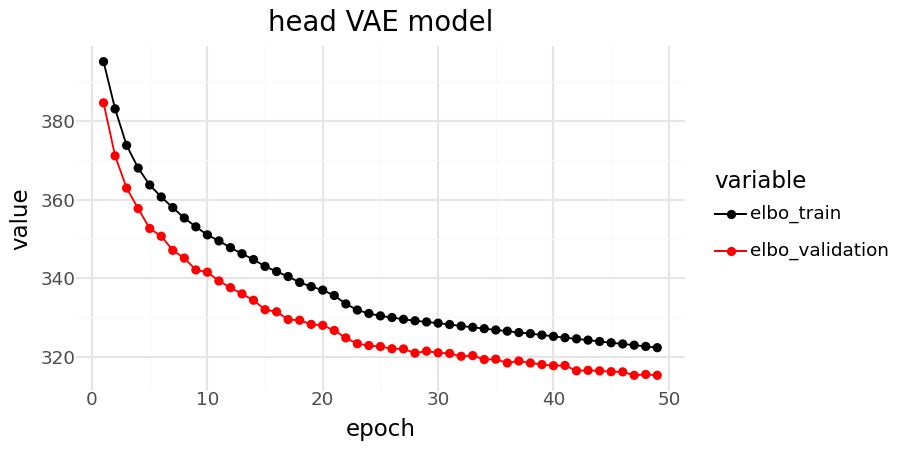

In [22]:
history_df = (
    broad_annotation_vae.history['elbo_train'].astype(float)
    .join(broad_annotation_vae.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 6, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.ggtitle("head VAE model")
    + p.theme_minimal()
)


print(p_)

In [23]:
full_annotation_vae = sca.models.SCANVI.from_scvi_model(vae,adata=combined, unlabeled_category="Unlabeled",labels_key="annotation")
full_annotation_vae.train(max_epochs=50, check_val_every_n_epoch = 1)

INFO     Training for 50 epochs.                                                                                   


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:183: UserWarning: Category 14 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:56: UserWarning: Category 14 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: Fal

Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 2/50:   2%|▏         | 1/50 [00:16<13:22, 16.38s/it, v_num=1, train_loss_step=342, train_loss_epoch=358]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 3/50:   4%|▍         | 2/50 [00:32<13:09, 16.44s/it, v_num=1, train_loss_step=328, train_loss_epoch=330]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 4/50:   6%|▌         | 3/50 [00:49<12:54, 16.48s/it, v_num=1, train_loss_step=328, train_loss_epoch=323]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 5/50:   8%|▊         | 4/50 [01:05<12:38, 16.49s/it, v_num=1, train_loss_step=322, train_loss_epoch=319]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 6/50:  10%|█         | 5/50 [01:22<12:23, 16.51s/it, v_num=1, train_loss_step=309, train_loss_epoch=315]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 7/50:  12%|█▏        | 6/50 [01:38<12:05, 16.50s/it, v_num=1, train_loss_step=312, train_loss_epoch=313]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 8/50:  14%|█▍        | 7/50 [01:55<11:49, 16.50s/it, v_num=1, train_loss_step=319, train_loss_epoch=311]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 9/50:  16%|█▌        | 8/50 [02:11<11:33, 16.51s/it, v_num=1, train_loss_step=292, train_loss_epoch=309]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 10/50:  18%|█▊        | 9/50 [02:28<11:16, 16.50s/it, v_num=1, train_loss_step=320, train_loss_epoch=308]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 11/50:  20%|██        | 10/50 [02:45<11:01, 16.53s/it, v_num=1, train_loss_step=283, train_loss_epoch=306]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 12/50:  22%|██▏       | 11/50 [03:01<10:43, 16.51s/it, v_num=1, train_loss_step=267, train_loss_epoch=305]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 13/50:  24%|██▍       | 12/50 [03:18<10:27, 16.52s/it, v_num=1, train_loss_step=316, train_loss_epoch=304]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 14/50:  26%|██▌       | 13/50 [03:34<10:11, 16.52s/it, v_num=1, train_loss_step=322, train_loss_epoch=303]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 15/50:  28%|██▊       | 14/50 [03:51<09:54, 16.51s/it, v_num=1, train_loss_step=280, train_loss_epoch=302]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 16/50:  30%|███       | 15/50 [04:07<09:37, 16.51s/it, v_num=1, train_loss_step=282, train_loss_epoch=301]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 17/50:  32%|███▏      | 16/50 [04:24<09:21, 16.51s/it, v_num=1, train_loss_step=291, train_loss_epoch=300]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 18/50:  34%|███▍      | 17/50 [04:40<09:03, 16.48s/it, v_num=1, train_loss_step=317, train_loss_epoch=299]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 19/50:  36%|███▌      | 18/50 [04:57<08:47, 16.50s/it, v_num=1, train_loss_step=298, train_loss_epoch=299]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 20/50:  38%|███▊      | 19/50 [05:13<08:31, 16.49s/it, v_num=1, train_loss_step=316, train_loss_epoch=298]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 21/50:  40%|████      | 20/50 [05:29<08:14, 16.47s/it, v_num=1, train_loss_step=296, train_loss_epoch=297]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 22/50:  42%|████▏     | 21/50 [05:46<07:57, 16.45s/it, v_num=1, train_loss_step=283, train_loss_epoch=296]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 23/50:  44%|████▍     | 22/50 [06:02<07:41, 16.47s/it, v_num=1, train_loss_step=286, train_loss_epoch=296]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 24/50:  46%|████▌     | 23/50 [06:19<07:24, 16.47s/it, v_num=1, train_loss_step=293, train_loss_epoch=295]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 25/50:  48%|████▊     | 24/50 [06:35<07:07, 16.44s/it, v_num=1, train_loss_step=300, train_loss_epoch=294]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 26/50:  50%|█████     | 25/50 [06:52<06:50, 16.44s/it, v_num=1, train_loss_step=292, train_loss_epoch=294]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 27/50:  52%|█████▏    | 26/50 [07:08<06:34, 16.45s/it, v_num=1, train_loss_step=302, train_loss_epoch=293]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 28/50:  54%|█████▍    | 27/50 [07:25<06:18, 16.47s/it, v_num=1, train_loss_step=298, train_loss_epoch=293]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 29/50:  56%|█████▌    | 28/50 [07:41<06:03, 16.51s/it, v_num=1, train_loss_step=283, train_loss_epoch=292]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 30/50:  58%|█████▊    | 29/50 [07:58<05:46, 16.51s/it, v_num=1, train_loss_step=288, train_loss_epoch=291]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 31/50:  60%|██████    | 30/50 [08:14<05:29, 16.50s/it, v_num=1, train_loss_step=306, train_loss_epoch=291]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 32/50:  62%|██████▏   | 31/50 [08:31<05:13, 16.48s/it, v_num=1, train_loss_step=280, train_loss_epoch=291]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 33/50:  64%|██████▍   | 32/50 [08:47<04:56, 16.46s/it, v_num=1, train_loss_step=299, train_loss_epoch=290]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 34/50:  66%|██████▌   | 33/50 [09:03<04:39, 16.45s/it, v_num=1, train_loss_step=312, train_loss_epoch=290]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 35/50:  68%|██████▊   | 34/50 [09:20<04:22, 16.43s/it, v_num=1, train_loss_step=289, train_loss_epoch=290]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 36/50:  70%|███████   | 35/50 [09:36<04:06, 16.42s/it, v_num=1, train_loss_step=299, train_loss_epoch=289]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 37/50:  72%|███████▏  | 36/50 [09:53<03:49, 16.42s/it, v_num=1, train_loss_step=281, train_loss_epoch=289]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 38/50:  74%|███████▍  | 37/50 [10:09<03:33, 16.40s/it, v_num=1, train_loss_step=301, train_loss_epoch=289]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 39/50:  76%|███████▌  | 38/50 [10:25<03:16, 16.41s/it, v_num=1, train_loss_step=287, train_loss_epoch=288]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 40/50:  78%|███████▊  | 39/50 [10:42<03:00, 16.43s/it, v_num=1, train_loss_step=304, train_loss_epoch=288]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 41/50:  80%|████████  | 40/50 [10:58<02:44, 16.44s/it, v_num=1, train_loss_step=299, train_loss_epoch=288]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 42/50:  82%|████████▏ | 41/50 [11:15<02:27, 16.43s/it, v_num=1, train_loss_step=286, train_loss_epoch=288]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 43/50:  84%|████████▍ | 42/50 [11:31<02:11, 16.43s/it, v_num=1, train_loss_step=315, train_loss_epoch=288]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 44/50:  86%|████████▌ | 43/50 [11:48<01:55, 16.44s/it, v_num=1, train_loss_step=290, train_loss_epoch=287]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 45/50:  88%|████████▊ | 44/50 [12:04<01:38, 16.43s/it, v_num=1, train_loss_step=291, train_loss_epoch=287]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 46/50:  90%|█████████ | 45/50 [12:20<01:22, 16.41s/it, v_num=1, train_loss_step=262, train_loss_epoch=287]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 47/50:  92%|█████████▏| 46/50 [12:37<01:05, 16.41s/it, v_num=1, train_loss_step=298, train_loss_epoch=287]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 48/50:  94%|█████████▍| 47/50 [12:53<00:49, 16.42s/it, v_num=1, train_loss_step=276, train_loss_epoch=287]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 49/50:  96%|█████████▌| 48/50 [13:10<00:32, 16.41s/it, v_num=1, train_loss_step=266, train_loss_epoch=286]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 50/50:  98%|█████████▊| 49/50 [13:26<00:16, 16.41s/it, v_num=1, train_loss_step=289, train_loss_epoch=287]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution


Epoch 50/50: 100%|██████████| 50/50 [13:43<00:00, 16.41s/it, v_num=1, train_loss_step=305, train_loss_epoch=286]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [13:43<00:00, 16.46s/it, v_num=1, train_loss_step=305, train_loss_epoch=286]


/scratch/6735487.1.iris-gpu-pub/ipykernel_95065/3379340701.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


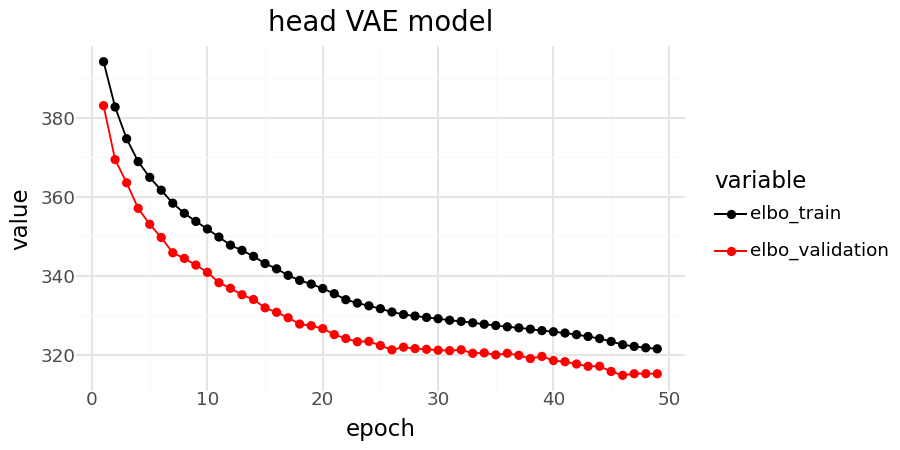

In [24]:
history_df = (
    full_annotation_vae.history['elbo_train'].astype(float)
    .join(full_annotation_vae.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 6, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.ggtitle("head VAE model")
    + p.theme_minimal()
)


print(p_)

In [25]:
broad_model = "/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/analysis/scarches/broad_model/"
broad_annotation_vae.save(broad_model, overwrite=True)
full_model = "/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/analysis/scarches/full_model/"
full_annotation_vae.save(full_model, overwrite=True)

In [26]:
combined.obs['broad_annotation_predicted'] = broad_annotation_vae.predict(combined)
combined.obs['full_annotation_predicted'] = full_annotation_vae.predict(combined)
combined.obs

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:183: UserWarning: Category 14 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:56: UserWarning: Category 14 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.


n_genes_by_counts  \
AAACCCAAGAGAGCAA-1                                              444.0   
AAACCCAAGCCGGATA-1                                              686.0   
AAACCCACATAATGCC-1                                              809.0   
AAACCCATCAAGGCTT-1                                              427.0   
AAACGAAAGGATACGC-1                                              766.0   
...                                                               ...   
TTTGGTTGTACGAAAT-f7ed0992__FCA15_Female_head_adult                NaN   
TTTGTTGCAACGCATT-f7ed0992__FCA15_Female_head_adult                NaN   
TTTGTTGTCATCGCCT-f7ed0992__FCA15_Female_head_adult                NaN   
TTTGTTGTCCATTCGC-f7ed0992__FCA15_Female_head_adult                NaN   
TTTGTTGTCGCTTGCT-f7ed0992__FCA15_Female_head_adult                NaN   

                                                    total_counts  \
AAACCCAAGAGAGCAA-1                                         823.0   
AAACCCAAGCCGGATA-1                                        1138.0   
AAACCCACATAATGCC-1                                        1573.0   
AAACCCATCAAGGCTT-1                                         693.0   
AAACGAAAGGATACGC-1                                        1424.0   
...                                                          ...   
TTTGGTTGTACGAAAT-f7ed0992__FCA15_Female_head_adult           NaN   
TTTGTTGCAACGCATT-f7ed0992__FCA15_Female_head_adult           NaN   
TTTGTTGTCATCGCCT-f7ed0992__FCA15_Female_head_adult           NaN   
TTTGTTGTCCATTCGC-f7ed0992__FCA15_Female_head_adult           NaN   
TTTGTTGTCGCTTGCT-f7ed0992__FCA15_Female_head_adult           NaN   

                                                    total_counts_mt  \
AAACCCAAGAGAGCAA-1                                              1.0   
AAACCCAAGCCGGATA-1                                              3.0   
AAACCCACATAATGCC-1                                              1.0   
AAACCCATCAAGGCTT-1                                              2.0   
AAACGAAAGGATACGC-1                                              4.0   
...                                                             ...   
TTTGGTTGTACGAAAT-f7ed0992__FCA15_Female_head_adult              NaN   
TTTGTTGCAACGCATT-f7ed0992__FCA15_Female_head_adult              NaN   
TTTGTTGTCATCGCCT-f7ed0992__FCA15_Female_head_adult              NaN   
TTTGTTGTCCATTCGC-f7ed0992__FCA15_Female_head_adult              NaN   
TTTGTTGTCGCTTGCT-f7ed0992__FCA15_Female_head_adult              NaN   

                                                    pct_counts_mt  n_genes  \
AAACCCAAGAGAGCAA-1                                       0.121507      444   
AAACCCAAGCCGGATA-1                                       0.263620      686   
AAACCCACATAATGCC-1                                       0.063573      809   
AAACCCATCAAGGCTT-1                                       0.288600      427   
AAACGAAAGGATACGC-1                                       0.280899      768   
...                                                           ...      ...   
TTTGGTTGTACGAAAT-f7ed0992__FCA15_Female_head_adult            NaN      335   
TTTGTTGCAACGCATT-f7ed0992__FCA15_Female_head_adult            NaN      444   
TTTGTTGTCATCGCCT-f7ed0992__FCA15_Female_head_adult            NaN      389   
TTTGTTGTCCATTCGC-f7ed0992__FCA15_Female_head_adult            NaN     1093   
TTTGTTGTCGCTTGCT-f7ed0992__FCA15_Female_head_adult            NaN      468   

                                                    log1p_n_genes_by_counts  \
AAACCCAAGAGAGCAA-1                                                 6.098074   
AAACCCAAGCCGGATA-1                                                 6.532334   
AAACCCACATAATGCC-1                                                 6.697034   
AAACCCATCAAGGCTT-1                                                 6.059123   
AAACGAAAGGATACGC-1                                                 6.642487   
...                                                                     ...   
TTTGGTTGTACGAAA

In [27]:
broad_annotation_mappings = dict(zip(combined.obs.index, combined.obs.broad_annotation_predicted))
full_annotation_mappings = dict(zip(combined.obs.index, combined.obs.full_annotation_predicted))

In [28]:
query.obs['broad_annotation'] = query.obs.index.map(broad_annotation_mappings)
query.obs['full_annotation'] = query.obs.index.map(full_annotation_mappings)

In [29]:
print(query.X.max(),query.X.min())

1089.0 0.0


In [30]:
query_labeled = query.copy()

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [31]:
query_labeled.layers['raw_counts'] = query_labeled.X
sc.pp.normalize_total(query_labeled)
sc.pp.log1p(query_labeled)
sc.pp.highly_variable_genes(query_labeled,
                            batch_key="tissue_batch",
                            n_top_genes=2000,
                            subset=False)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [32]:
query_labeled.raw = query_labeled
sc.tl.pca(query_labeled, n_comps=200)


computing PCA
    with n_comps=200
    finished (0:00:02)


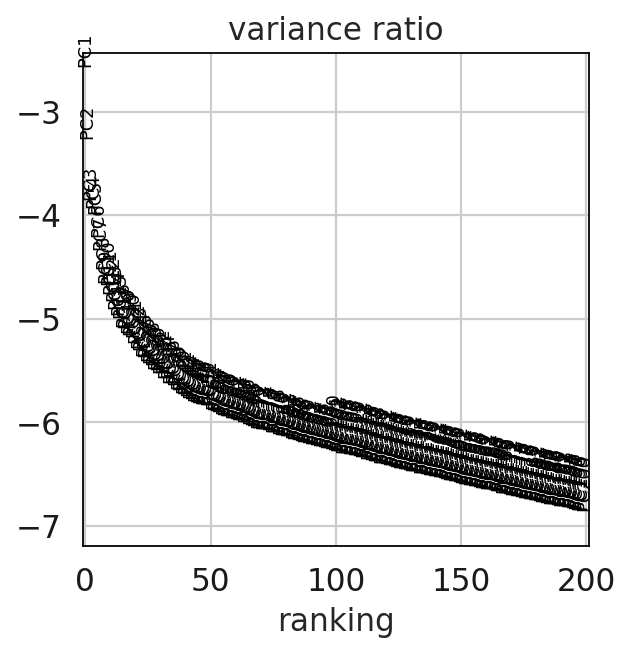

In [33]:
sc.pl.pca_variance_ratio(query_labeled, n_pcs=200, log=True)

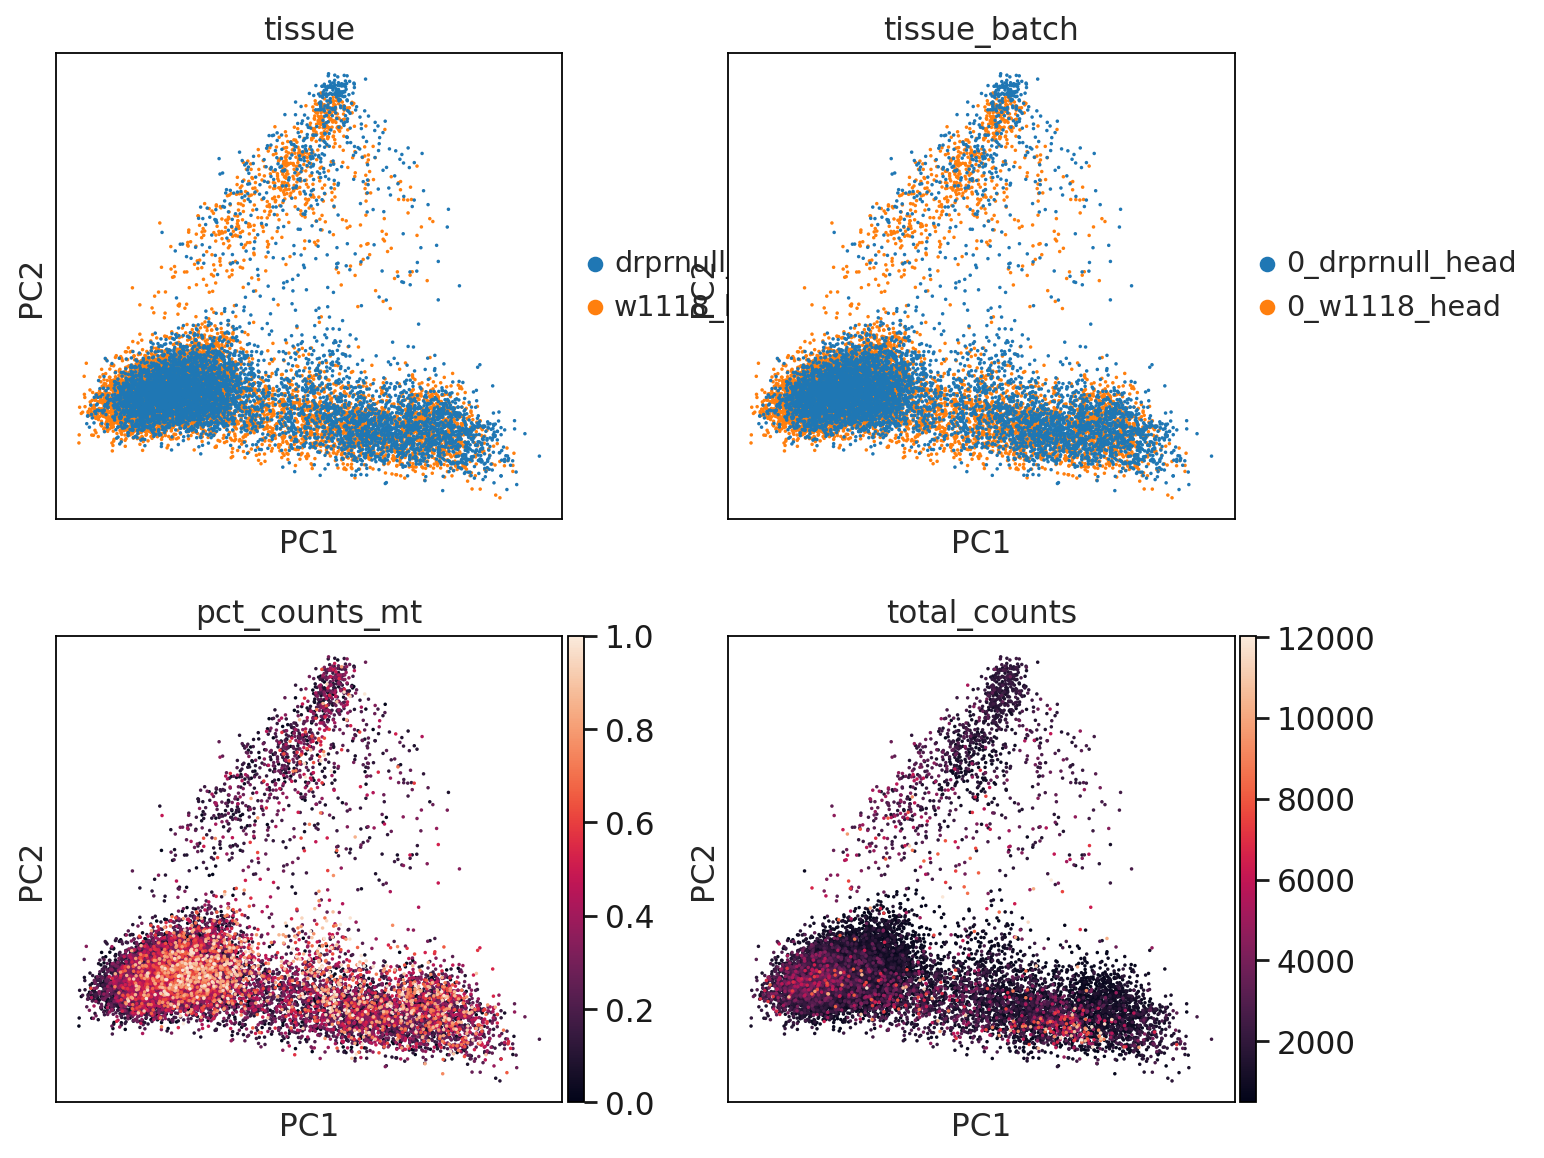

In [34]:
sc.pl.pca(
    query_labeled,
    color=["tissue", "tissue_batch", "pct_counts_mt", "total_counts"],
    ncols=2,
    size=10
)

In [35]:
sc.pp.neighbors(query_labeled)
sc.tl.umap(query_labeled)

computing neighbors
    using 'X_pca' with n_pcs = 200
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


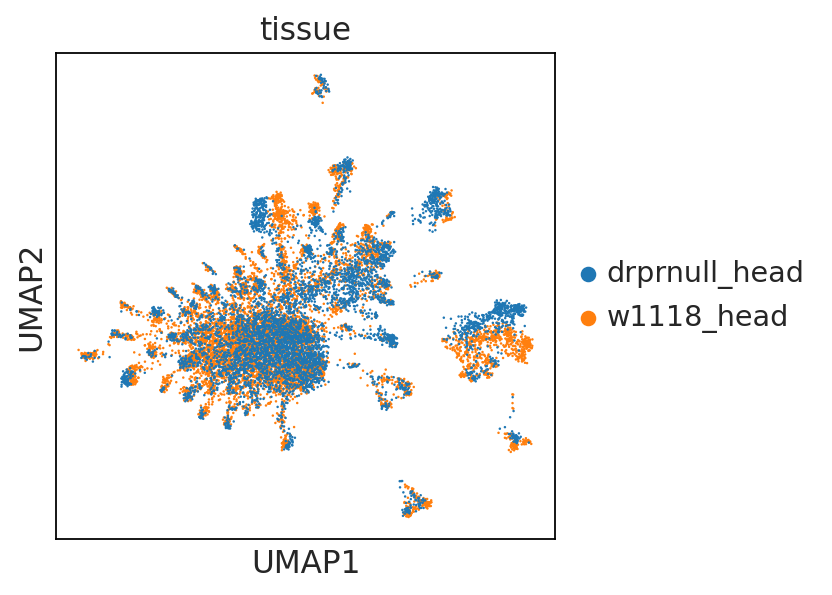

In [36]:
sc.pl.umap(
    query_labeled,
    color="tissue",
    # Setting a smaller point size to get prevent overlap
    size=5,
)

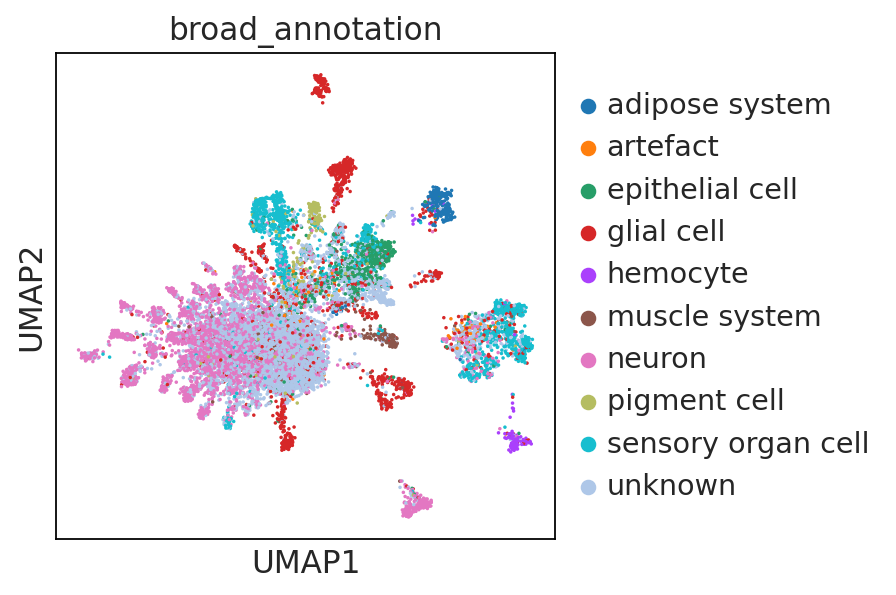

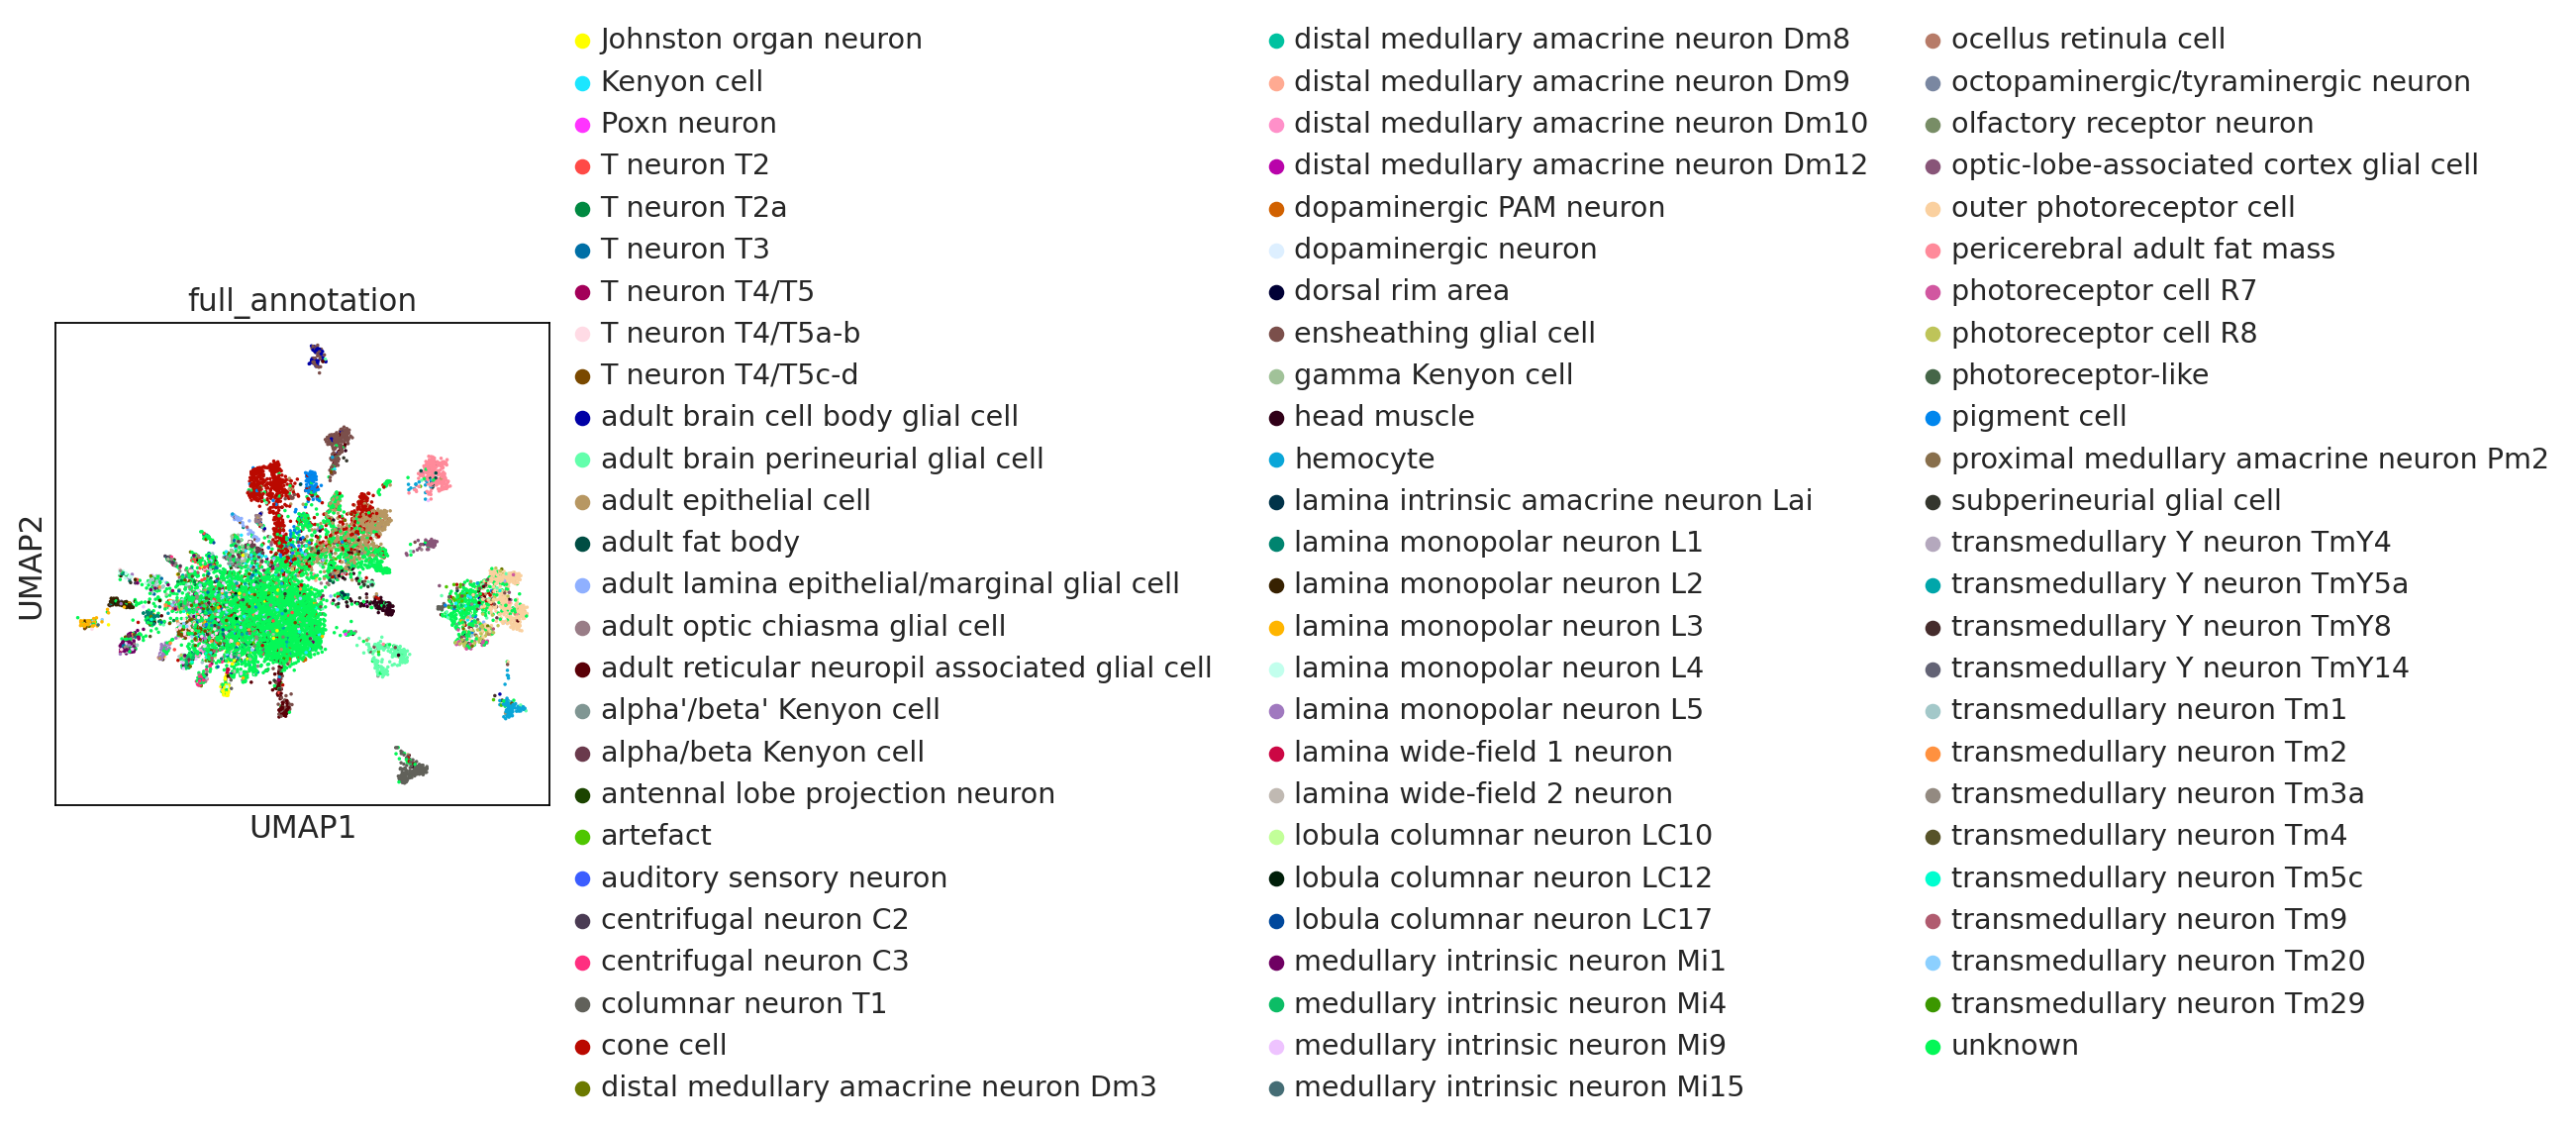

In [37]:
sc.pl.umap(
    query_labeled,
    color=["broad_annotation"],
    size=10,ncols=1
)

sc.pl.umap(
    query_labeled,
    color=["full_annotation"],
    size=10,ncols=1
)

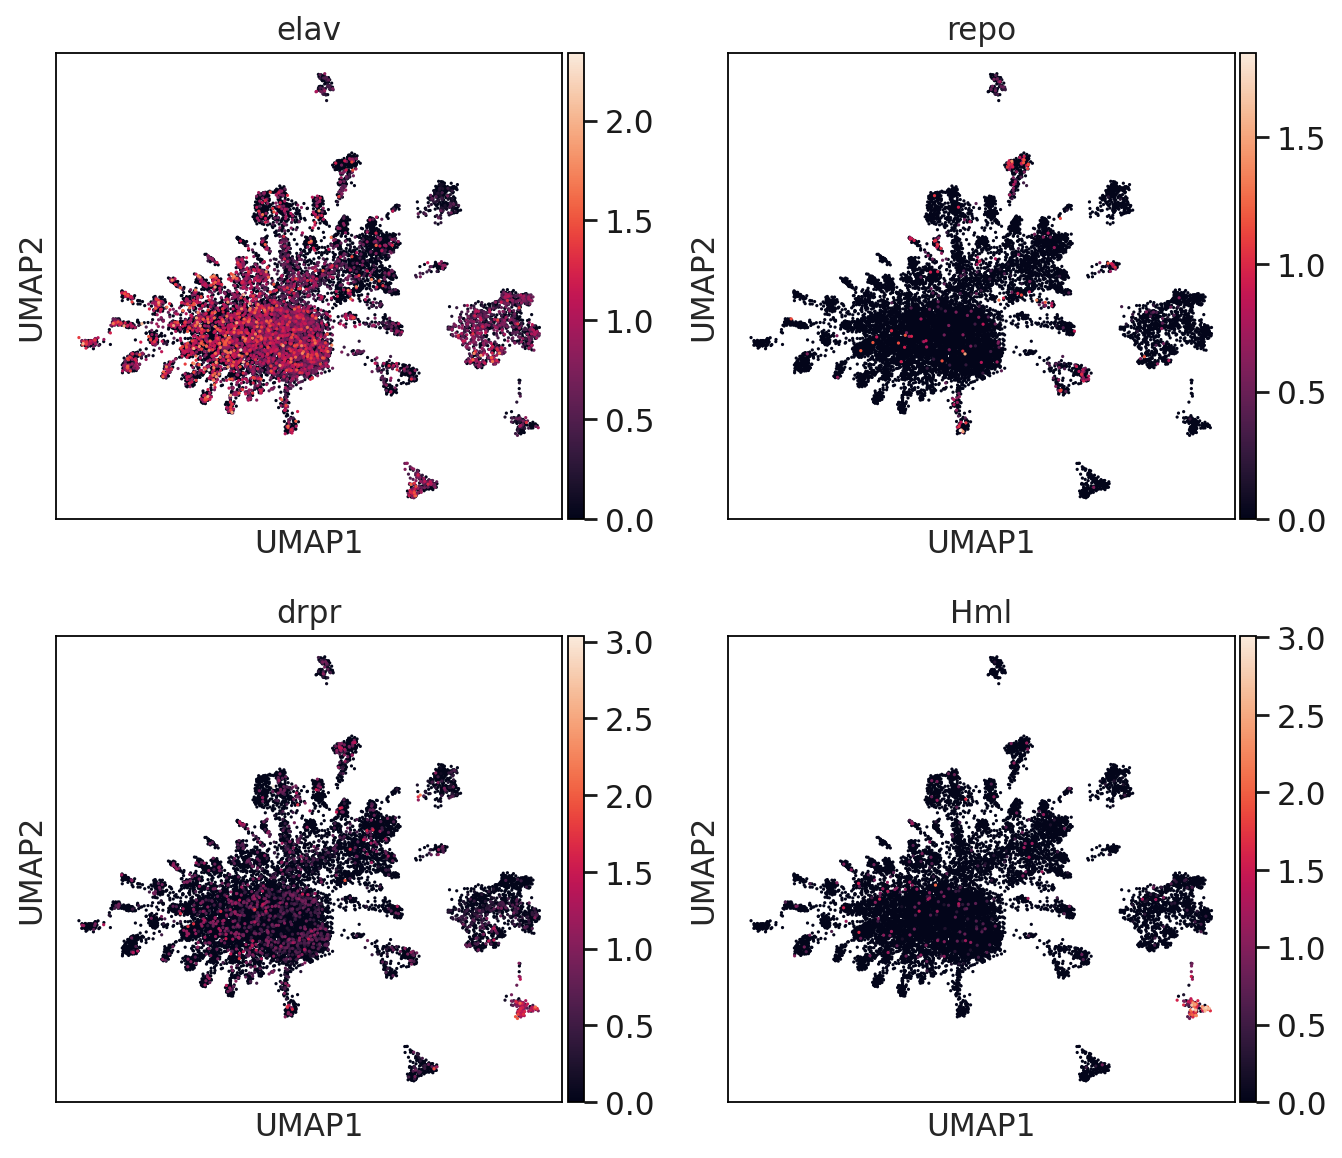

In [43]:
sc.pl.umap(
    query_labeled,
    color=["elav", "repo", "drpr","Hml"], ncols=2
)

In [39]:
markers = {"neurons": ["elav","lncRNA:noe","VAChT","VGlut","Gad1","Vmat","SerT","Tdc2","ple"], # neurons
           "glia": ["repo","lncRNA:CR34335","alrm","wrapper","Indy","moody"],#glia 
           "photoreceptors": ["ninaC",	"trp",	"trpl"], #photoreceptors
           "hemocytes": ["Hml"], #hemocytes
           "fatbody": ["ppl"],#fatbody
           "drpr":["drpr"]}

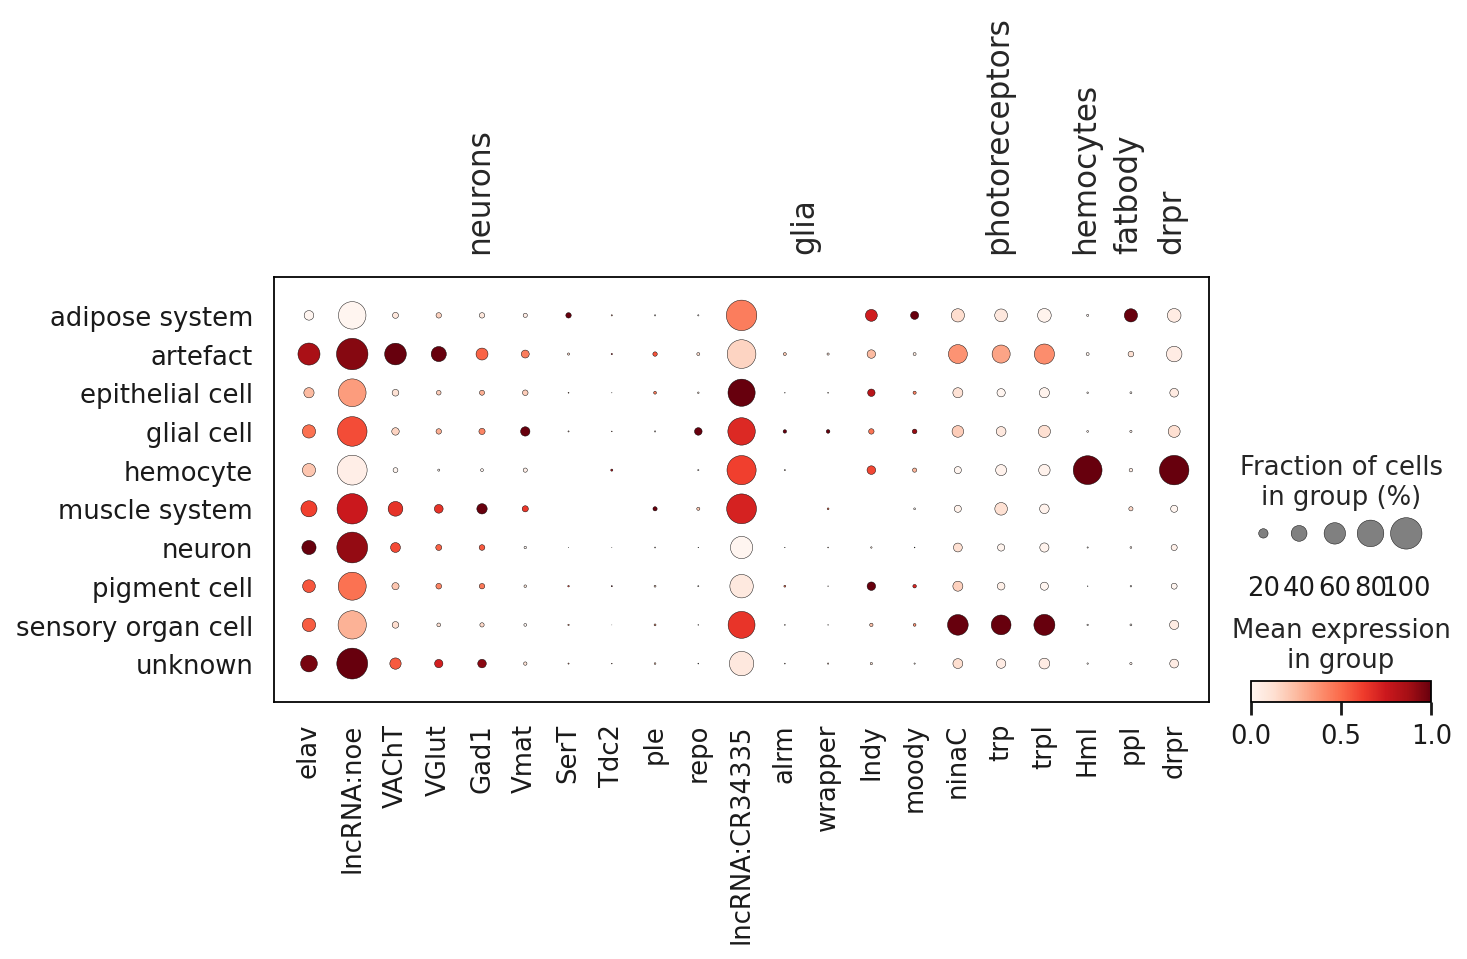

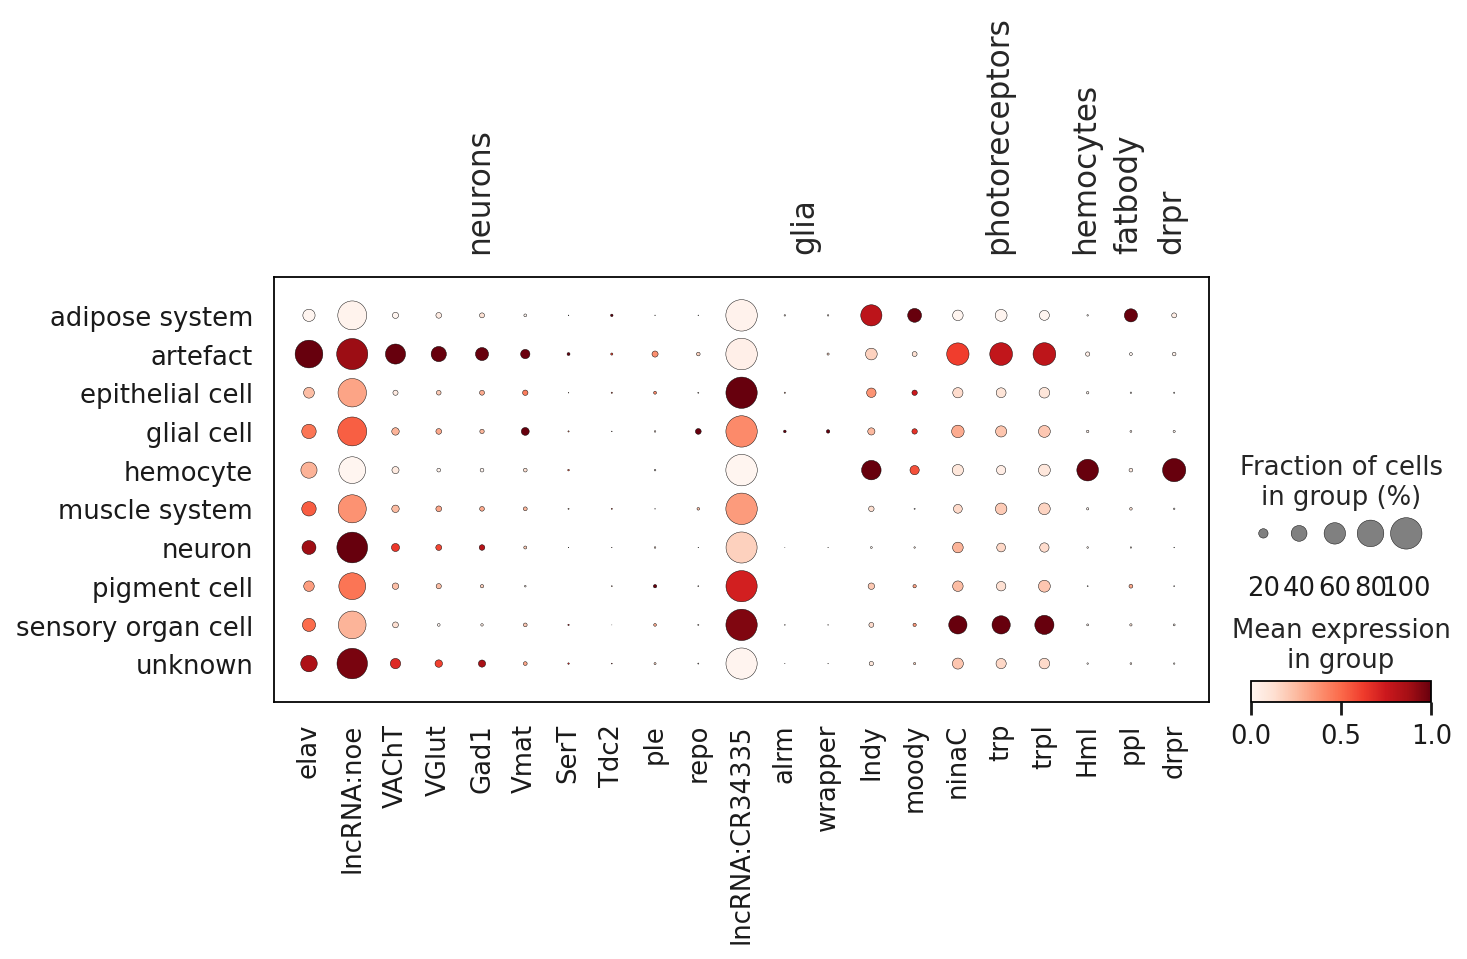

In [40]:

sc.pl.dotplot(query_labeled[query_labeled.obs['tissue']=="w1118_head"], markers, groupby="broad_annotation", standard_scale="var")
sc.pl.dotplot(query_labeled[query_labeled.obs['tissue']=="drprnull_head"], markers, groupby="broad_annotation", standard_scale="var")

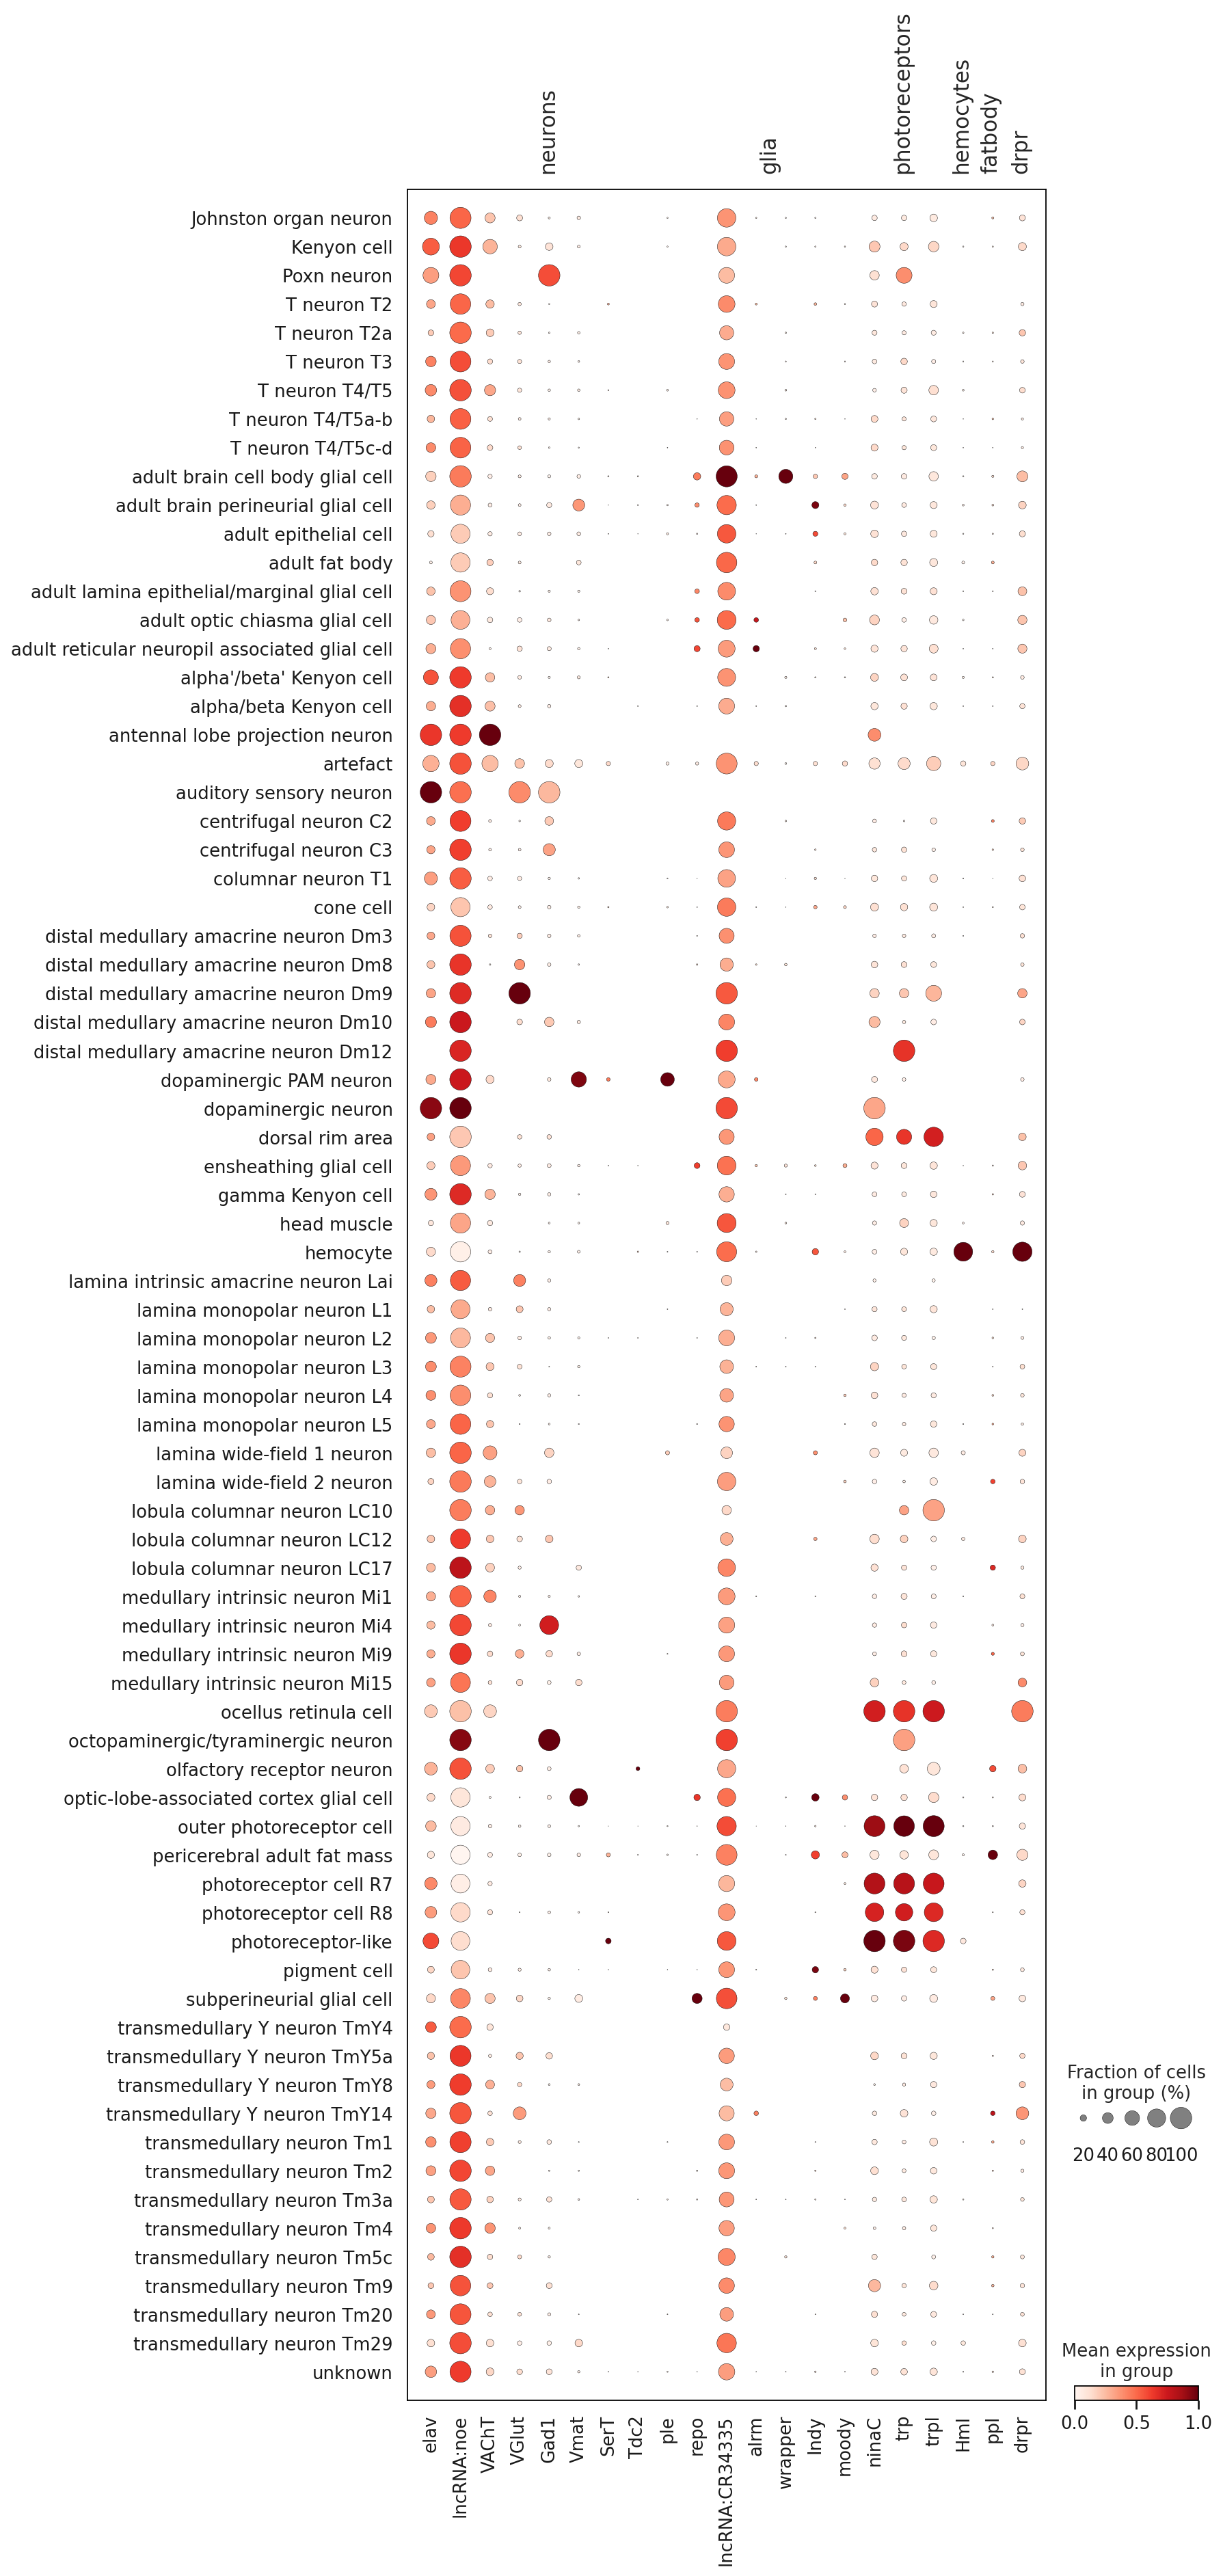

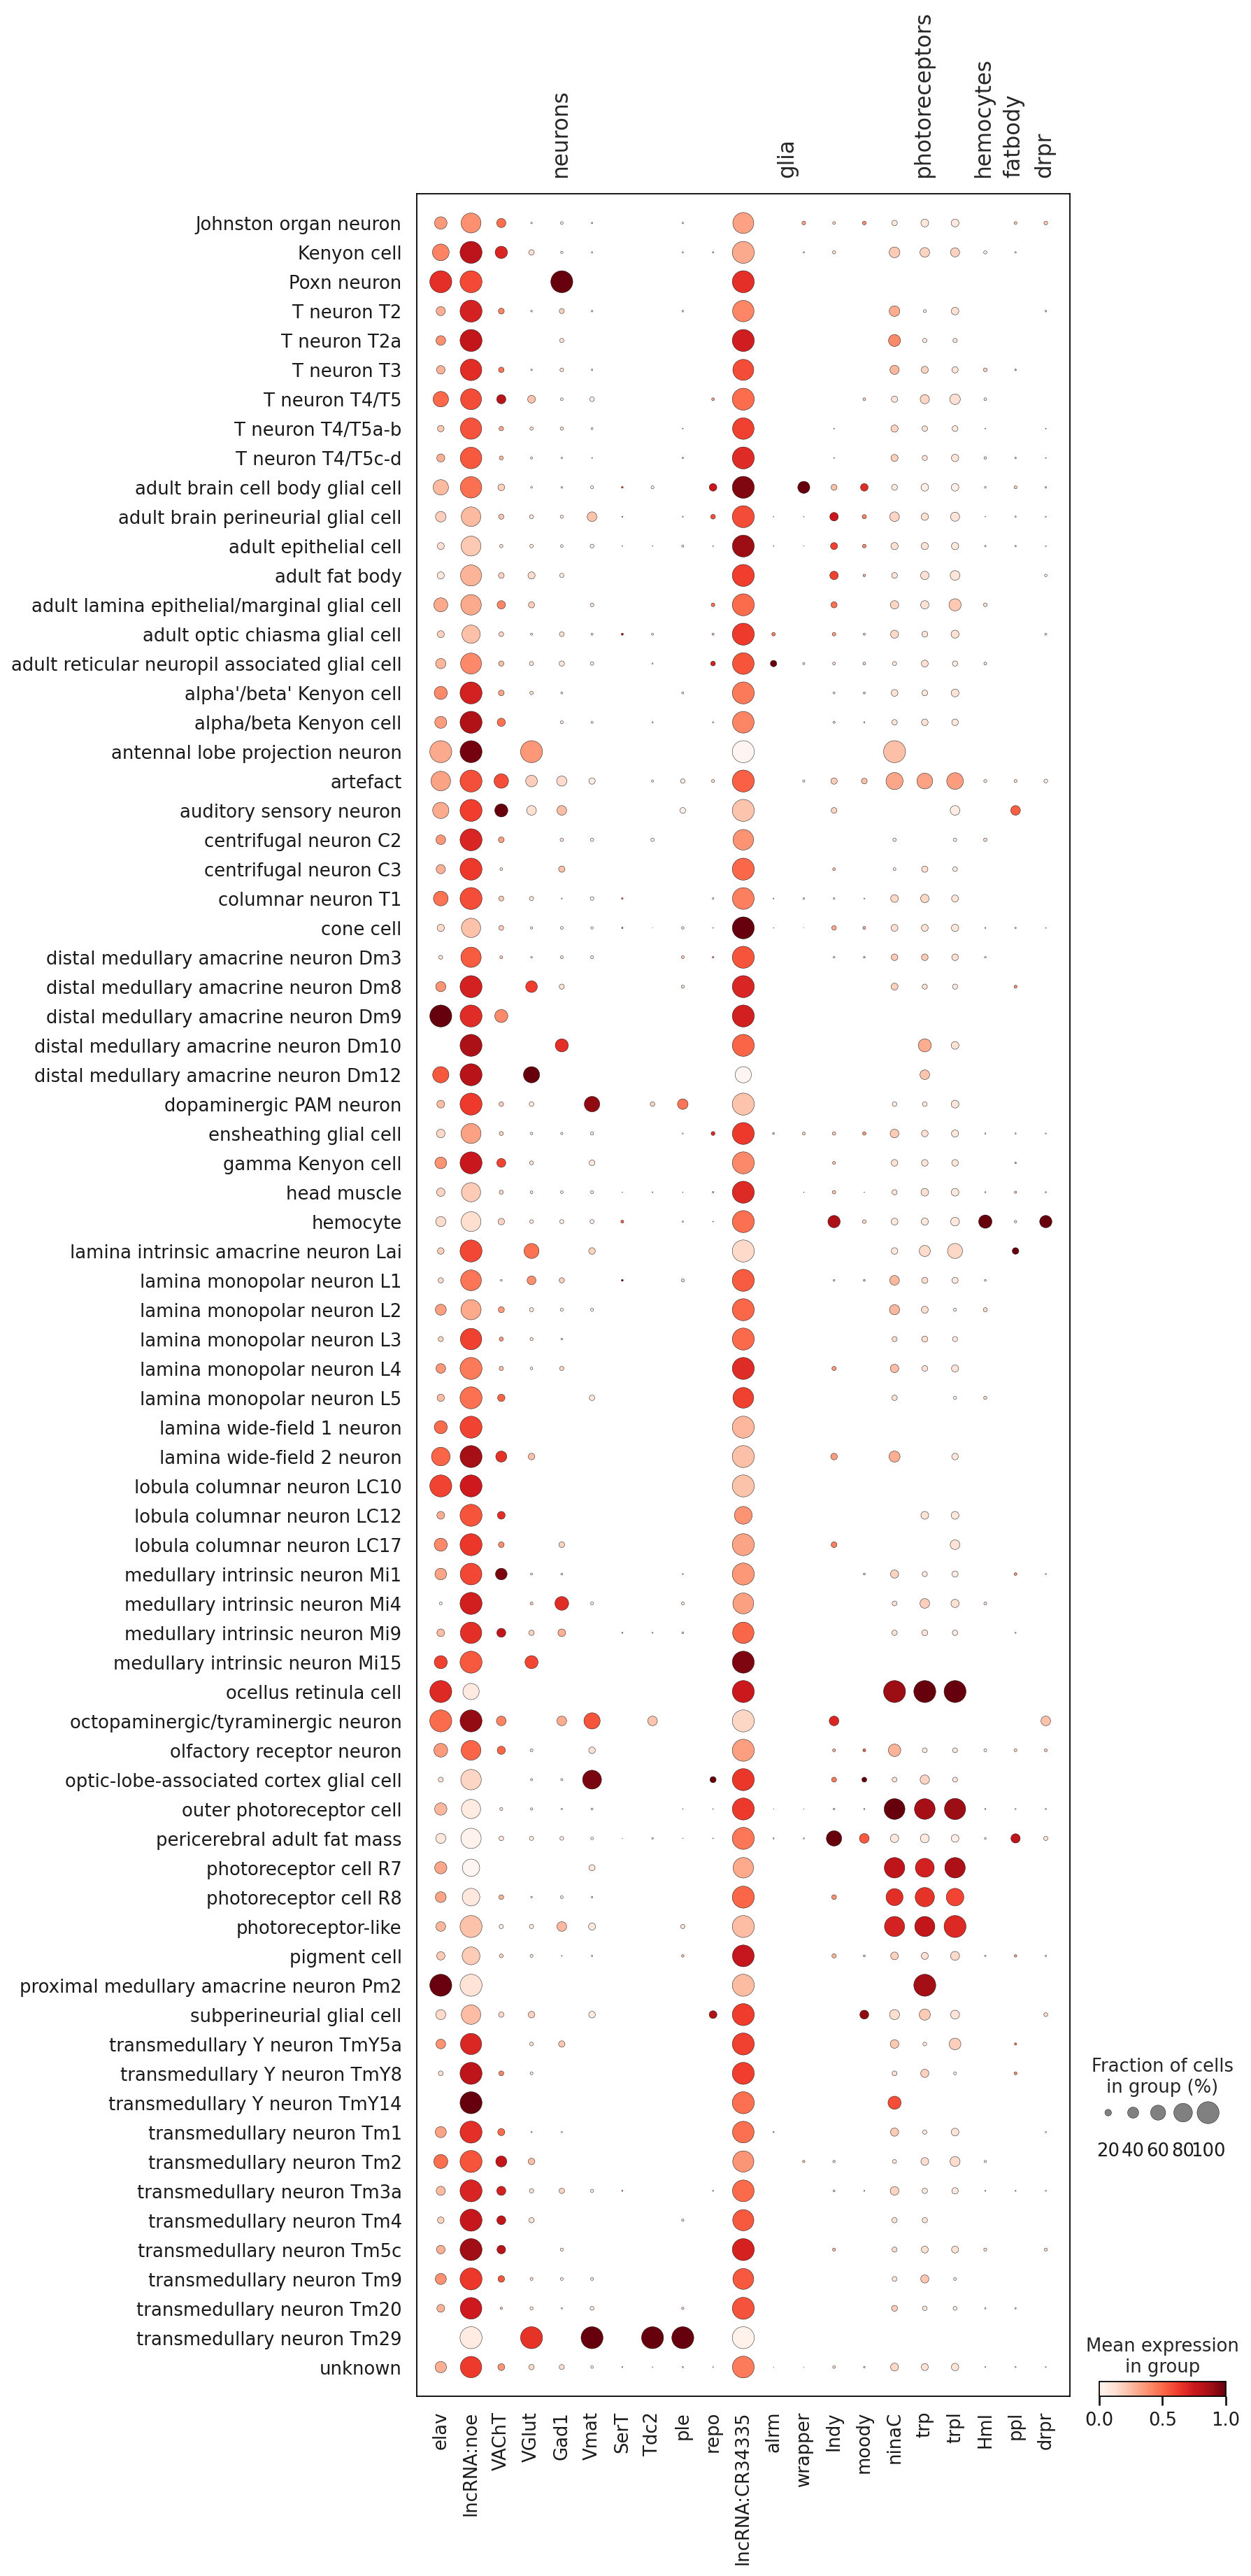

In [41]:
sc.pl.dotplot(query_labeled[query_labeled.obs['tissue']=="w1118_head"], markers, groupby="full_annotation", standard_scale="var")
sc.pl.dotplot(query_labeled[query_labeled.obs['tissue']=="drprnull_head"], markers, groupby="full_annotation", standard_scale="var")

In [42]:
#combined.write(outputpath.joinpath("combined.h5"))
query.write(outputpath.joinpath("query.h5"))
query_labeled.write(outputpath.joinpath("query_labeled.h5"))